* This notebook was made to look at the alongshore, cross-starit transport of fresh water, total water amount of each run.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from R_mixStuff import sites
from R_mixStuff import strings
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '7':{'jst':36, 'ist':100,'jen':37,'ien':101},
            '5':{'jst':34, 'ist':94,'jen':36,'ien':95}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
umask = mesh.variables['umask'][0,:,380:510,240:397]
vmask = mesh.variables['vmask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]
e3v = mesh.variables['e3v'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.95, 49.4)

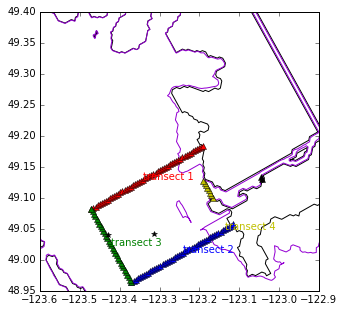

In [5]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[sites['VENUS Central']['j'],sites['VENUS Central']['i']],\
         Y[sites['VENUS Central']['j'],sites['VENUS Central']['i']],'k*')
ax.plot(X[sites['VENUS East']['j'],sites['VENUS East']['i']],\
         Y[sites['VENUS East']['j'],sites['VENUS East']['i']],'k*')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.6,-122.9])
ax.set_ylim([48.95,49.4])

In [6]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']

In [7]:
def transport_time (S,U,V,ssh,lon,lat,depU,depV,tran,string ='specific time',fresh_flag = False):
    """This subfunction was made only to calculate the 
       transport/freshwater transport of a transect at the specific time"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4': ## cross-shelf transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']-1).shape[0]])
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst']+j,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j,transects[tran]['ist']], \
                        lon[transects[tran]['jst']+j+1,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j+1,transects[tran]['ist']])
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t][z,j,0])/30
                        adj_ssh = 1+ssh[pa][strings[string][t],j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3u[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*umask[:,j+transects[tran]['jst'],transects[tran]['ist']])
                        
                        trans[pa][t][z,j] = U[pa][t][z,j,0]*d*1000*e3u[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']-1).shape[0]]);
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst'],transects[tran]['ist']+i],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i], \
                        lon[transects[tran]['jst'],transects[tran]['ist']+i+1],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i+1])
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t][z,0,i])/30

                        adj_ssh = 1+ssh[pa][strings[string][t],transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3v[:,transects[tran]['jst'],i+transects[tran]['ist']]*vmask[:,transects[tran]['jst'],i+transects[tran]['ist']])
                        
                        trans[pa][t][z,i] = V[pa][t][z,0,i]*d*1000*e3v[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = {}; trans_total[pa] ={}
        for t in strings[string]:
            trans_surf[pa][t] = np.nansum(trans[pa][t],axis = 1)[0]
            trans_total[pa][t] = np.nansum(trans[pa][t])
 
    return trans, trans_surf,trans_total

In [8]:
def transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,string ='specific time',\
                         fresh_flag = False,y0lim =6e5, y1lim = 6000):
    """ This function was made to calculate the total transport (False)
        or fresh water transport (True) in the entire water column at specific 
        time or averaged low/high tides along the north/south cross-strait
        transect or along-shore transect .
    """
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(2, 2,width_ratios=[1,2], height_ratios=[1, 1])  
    gs.update(hspace=0.15, wspace=0.15)
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    if string == 'specific time' or string =='current time':
        for pa in paths:
            UU[pa] = {}; VV[pa] = {}; SS[pa] = {}
        for t in strings[string]:
            for pa in paths:
                SS[pa][t] = S[pa][strings[string][t],:,jinds,iinds]          
                mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
                SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask    
                
                               
                u,v = viz_tools.unstagger(U[pa][strings[string][t],:,jinds,iinds],\
                                          V[pa][strings[string][t],:,jinds,iinds])
                #rotate
                theta = np.pi*29/180
                UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
                VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
        trans,trans_sur,trans_to = transport_time(SS,UU,VV,ssh,lon,lat,depU,depV,tran,string = string,\
                                                 fresh_flag = fresh_flag) ## get surface/total transport
        ## location
        ax = fig.add_subplot(gs[0,0])
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_xlim([-123.6,-122.9])
        ax.set_ylim([48.95,49.4])
        if tran =='3' or tran =='4':
            ax.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],\
            Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],'ro')
        else:
            ax.plot(X[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],\
            Y[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],'ro')
        ax.annotate ('transect '+tran,(X[transects[tran]['jst'],transects[tran]['ist']],\
                    Y[transects[tran]['jst'],transects[tran]['ist']]), xycoords="data",color = 'r')
        ## total transport
        ax = fig.add_subplot(gs[0,1])
        cs = ['g','r','m','k','y']
        transurf = {}; trantotal = {} ## turn a dict to list
        for pa in paths:
            transurf[pa] = []; trantotal[pa] = [];
            transurf[pa] = [trans_sur[pa]['t_ind_low'],trans_sur[pa]['middle of flood'],trans_sur[pa]['t_ind_high']]
            trantotal[pa] = [trans_to[pa]['t_ind_low'],trans_to[pa]['middle of flood'],trans_to[pa]['t_ind_high']]
            
        for pa,c in zip(paths,cs):
            ax.plot(trantotal[pa],'-*',color = c,label = pa)
            print (pa,trantotal[pa])
        ax.set_ylim([-y0lim,y0lim])
        ## surface transport
        ax = fig.add_subplot(gs[1,1]) 
        for pa,c in zip(paths,cs):
            ax.plot(transurf[pa],'-.*',color = c,label = pa)
        ax.set_ylim([-y1lim,y1lim]) 
        for ax in [fig.add_subplot(gs[0,1]),fig.add_subplot(gs[1,1])]:
            ax.legend(loc = 'best')
            ax.grid('on')
            plt.setp(ax, xticks=[0, 1, 2], xticklabels=['low tide','middle of flood','high tide'])
            if fresh_flag == False:
                ax.set_ylabel('Total transport [m^3/s]')
            else:
                ax.set_ylabel('Fresh water transport [m^3/s]')
    return fig

In [9]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """Same as transport_calculate function, but focus on a continous time period rather 
    than a specific time"""
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(2, 2,width_ratios=[1,2], height_ratios=[1, 1])  
    gs.update(hspace=0.15, wspace=0.15)
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st,t_en+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            u,v = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
            #rotate
            theta = np.pi*29/180
            UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
            VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                 fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to,VV

In [10]:
def transport_time_general(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']-1).shape[0]])
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst']+j,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j,transects[tran]['ist']], \
                        lon[transects[tran]['jst']+j+1,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j+1,transects[tran]['ist']])
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j,0])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3u[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*umask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*1000*e3u[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']-1).shape[0]]);
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst'],transects[tran]['ist']+i],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i], \
                        lon[transects[tran]['jst'],transects[tran]['ist']+i+1],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i+1])
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,0,i])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3v[:,transects[tran]['jst'],i+transects[tran]['ist']]*vmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*1000*e3v[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st:t_en+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st:t_en+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [11]:
def uvs_contour(U,V,S,depU,depV,pa,tran,ind,string = 'specific time',st = 't_ind_high'):
    """This function was made to look at the u,v contour along transect
     at a specific time"""
    fig,axs =plt.subplots(3,1,figsize = (16,14))
    UU = {}; VV= {}; SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    UU[pa] = {}; VV[pa] = {}; SS[pa] = {};

    SS[pa][st] = S[pa][strings[string][st],:,jinds,iinds]
    mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
    SS[pa][st] = np.ma.masked_array(SS[pa][st],mask=mask) ## mask sal=0 by tmask    
    u,v = viz_tools.unstagger(U[pa][strings[string][st],:,jinds,iinds],\
                                          V[pa][strings[string][st],:,jinds,iinds])
    #rotate
    theta = np.pi*29/180
    UU[pa][st] = u*np.cos(theta) - v*np.sin(theta)
    VV[pa][st] = u*np.sin(theta) +v*np.cos(theta)
    if tran == '1' or tran =='2':
        islices = np.arange(transects[tran]['ien'] - transects[tran]['ist'])
        dep = depV
        VV[pa][st] = VV[pa][st][:,0,:]
        UU[pa][st] = UU[pa][st][:,0,:]
        SS[pa][st] =  SS[pa][st][:,0,:][:,:-1]
    else:
        islices = np.arange(transects[tran]['jen'] - transects[tran]['jst'])
        dep = depU
        UU[pa][st] = UU[pa][st][:,:,0]
        VV[pa][st] = VV[pa][st][:,:,0]
        SS[pa][st] =  SS[pa][st][:,:,0][:,:-1]

    ax = axs[0]
    cmap = plt.get_cmap('jet')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(islices, dep[:], SS[pa][st], cmap = cmap,vmin=0, vmax=30)
    ax.set_title('Salinity along trasect '+tran+pa)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Practical Salinity')
    for ax, ob,tl in zip ([axs[1],axs[2]], [UU[pa][st],VV[pa][st]],['U','V']):
        mesh = ax.contourf(islices,dep[:],ob, np.arange(-1.0,1.0+.1,.1),cmap = 'bwr')
        cbar = fig.colorbar(mesh, ax=ax)
        cbar.set_label(tl+' Velocity [m/s]')
        ax.set_title(tl +' along transect ' +tran+pa)        
    for ax in axs:
        ax.set_ylim([dep[ind], 0])
        ax.set_ylabel('depth [m]')
        ax.set_xlim([islices[0],islices[-1]])
        ax.set_xlabel('slices')

# Onlyriver

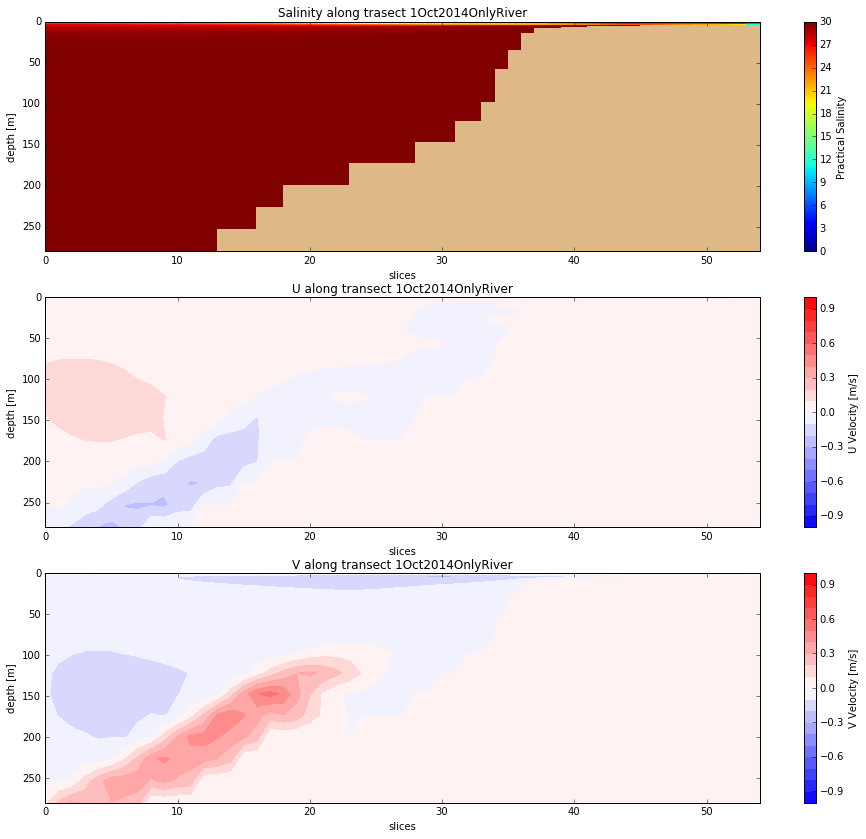

In [10]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','1',33,st = 't_ind_high')

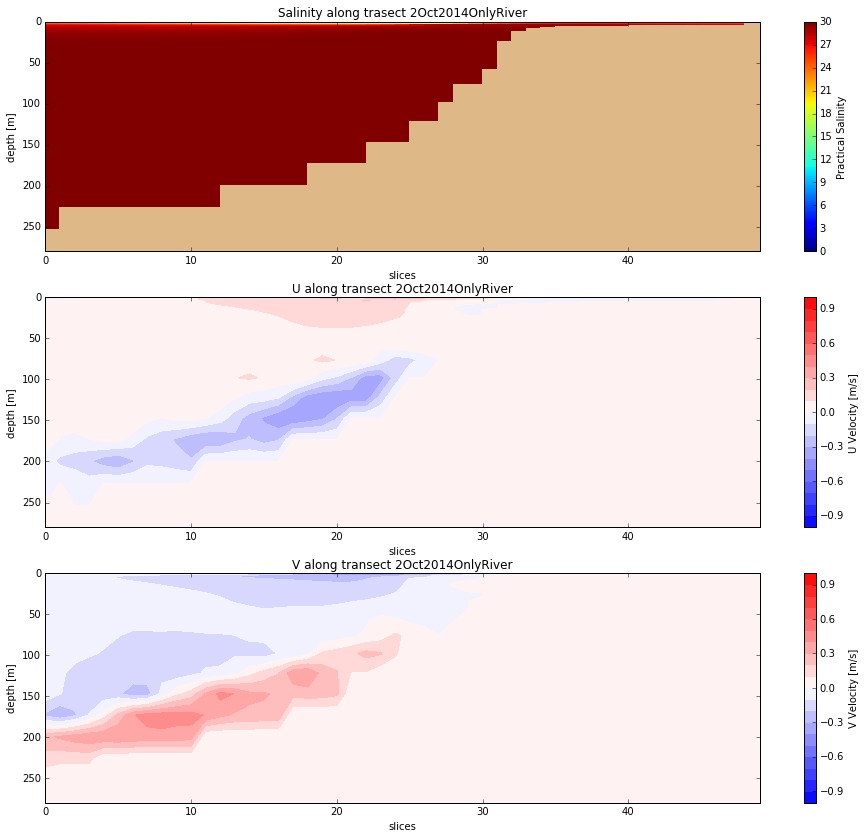

In [11]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','2',33,st = 't_ind_high')

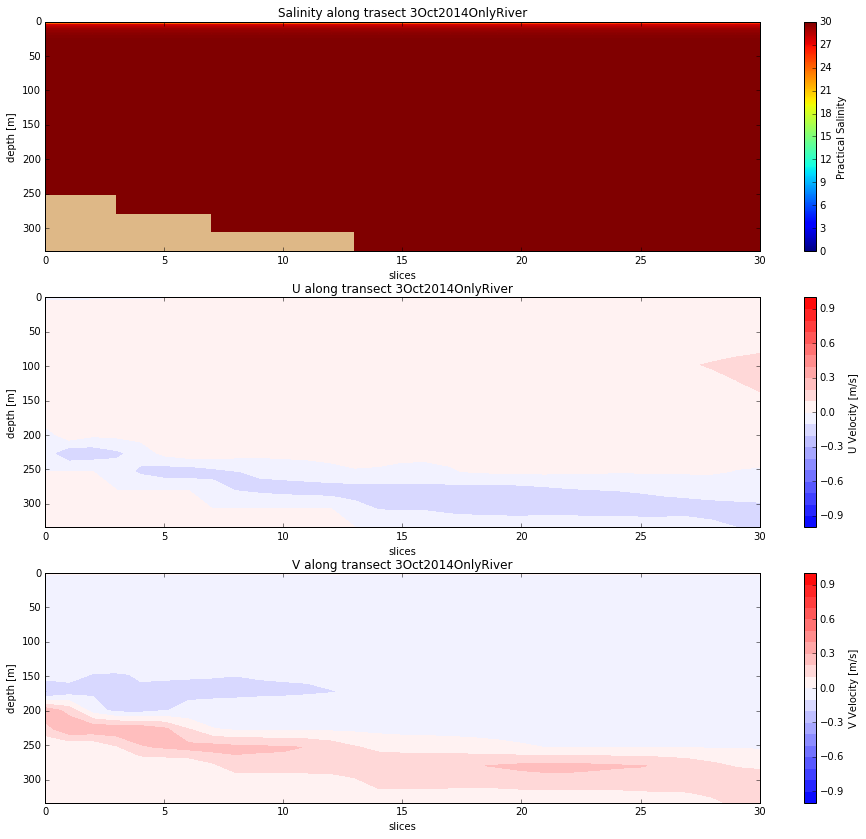

In [12]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','3',35,st = 't_ind_high')

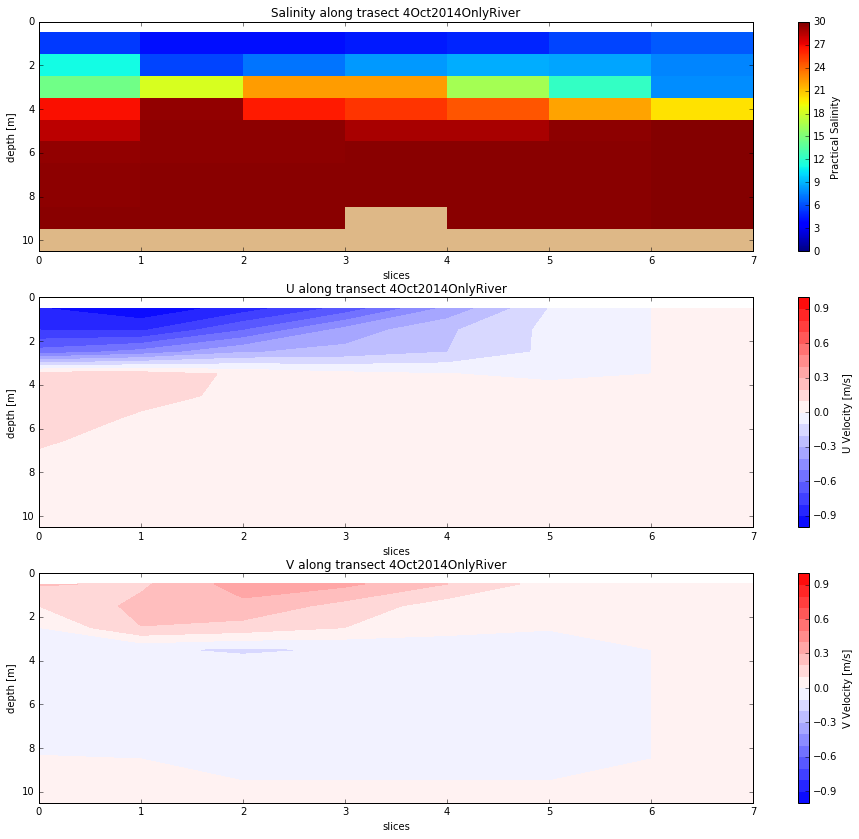

In [13]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','4',10,st = 't_ind_high')

# Nowinds

* transect1

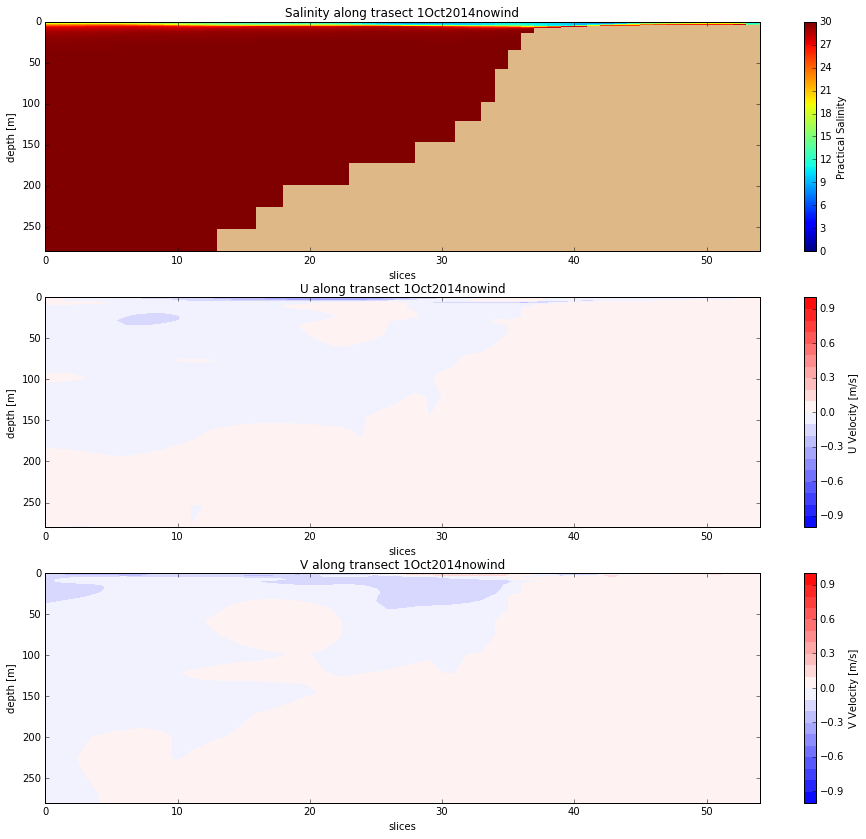

In [14]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','1',33,st = 't_ind_low')

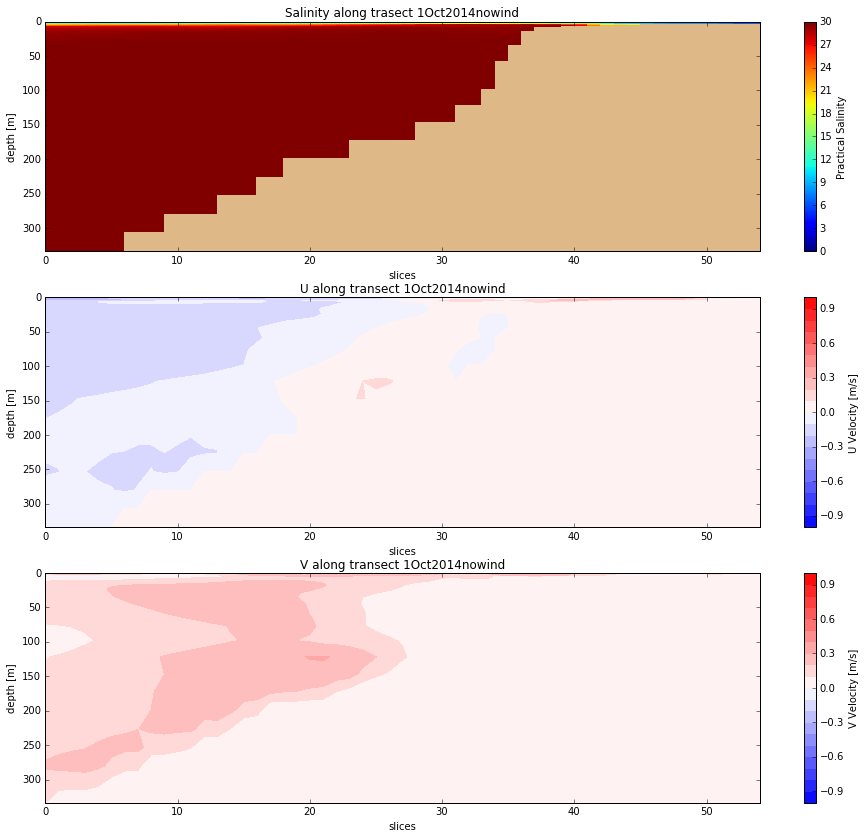

In [15]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','1',35,st = 'middle of flood')

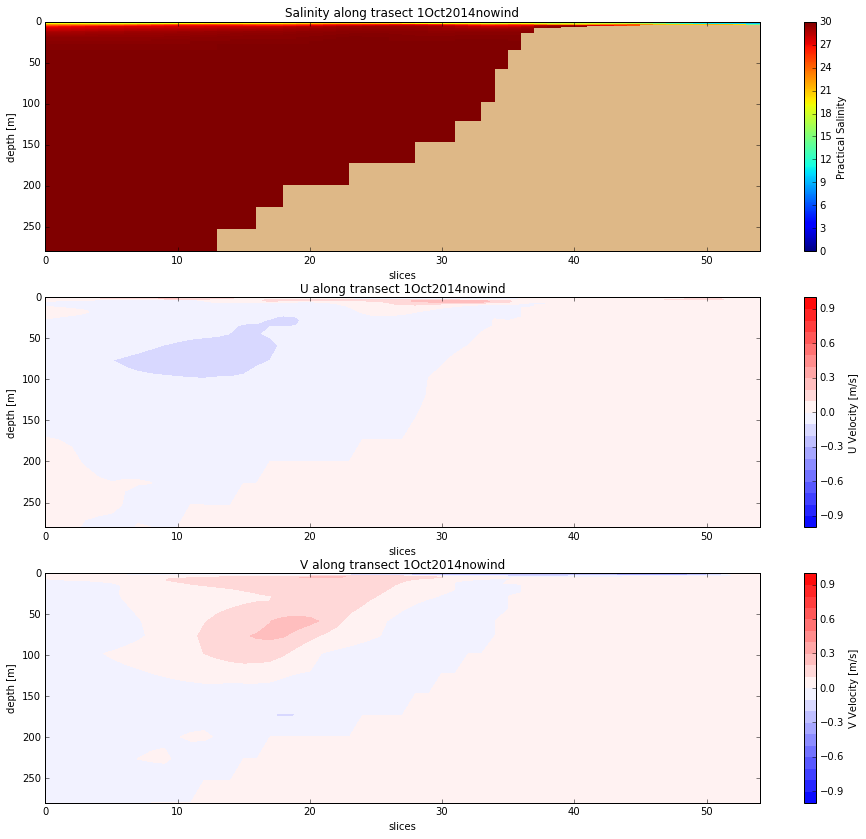

In [16]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','1',33,st = 't_ind_high')

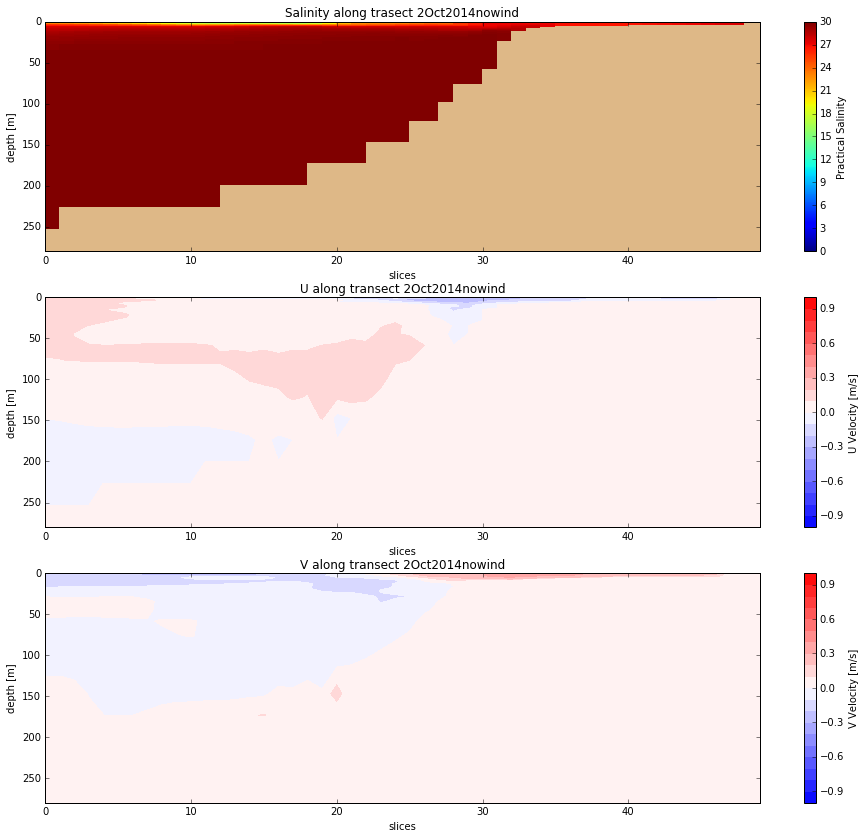

In [17]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','2',33,st = 't_ind_low')

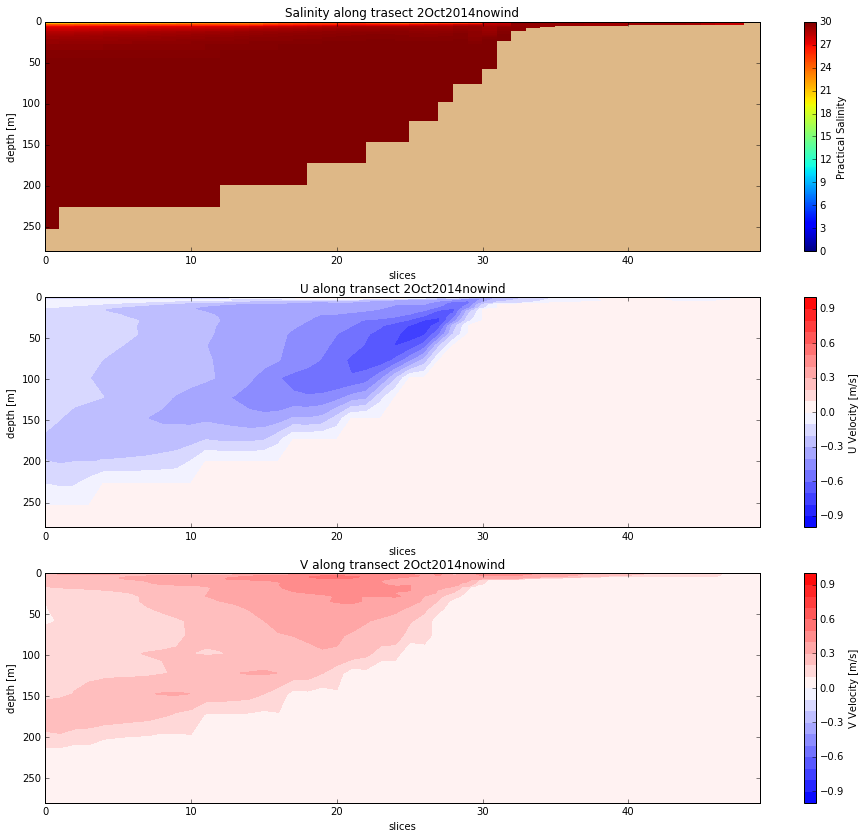

In [18]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','2',33,st = 'middle of flood')

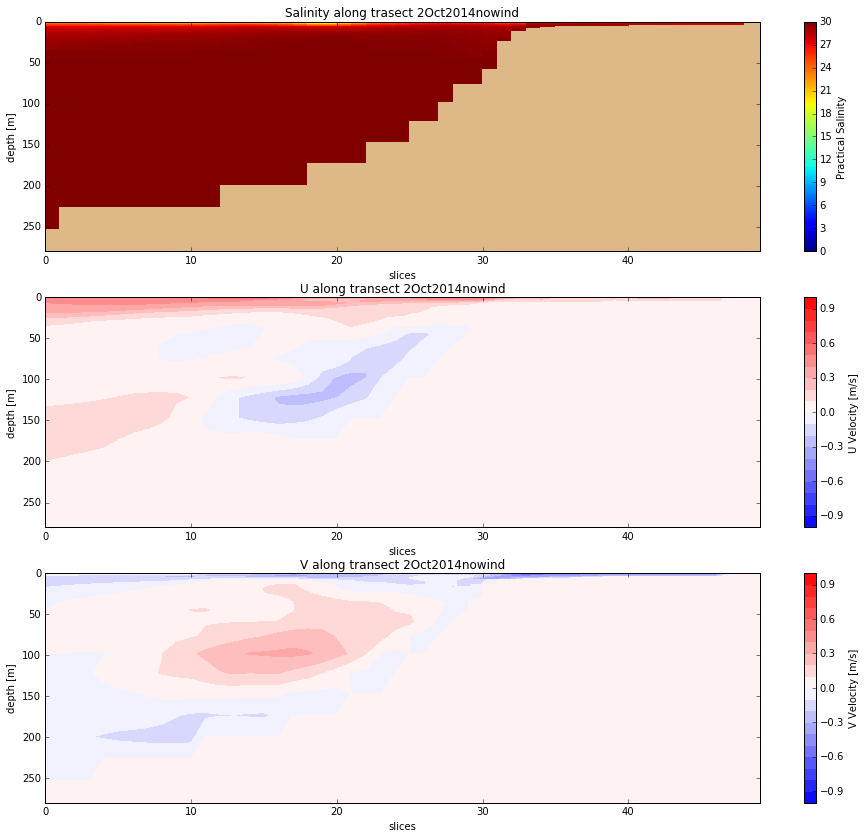

In [19]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','2',33,st = 't_ind_high')

* transect 3

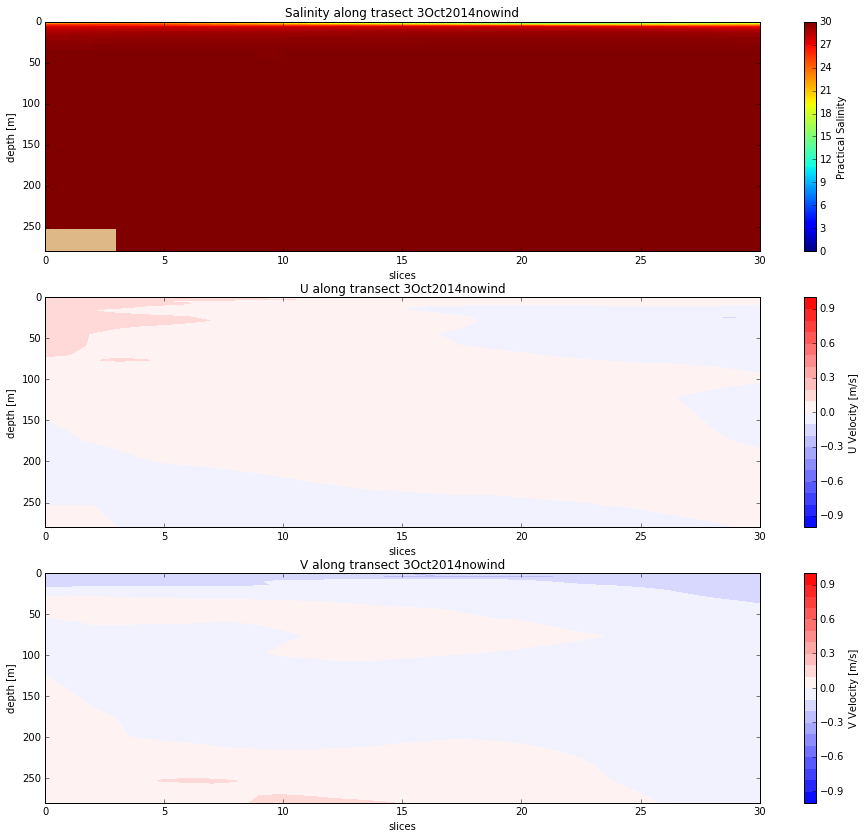

In [20]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','3',33,st = 't_ind_low')

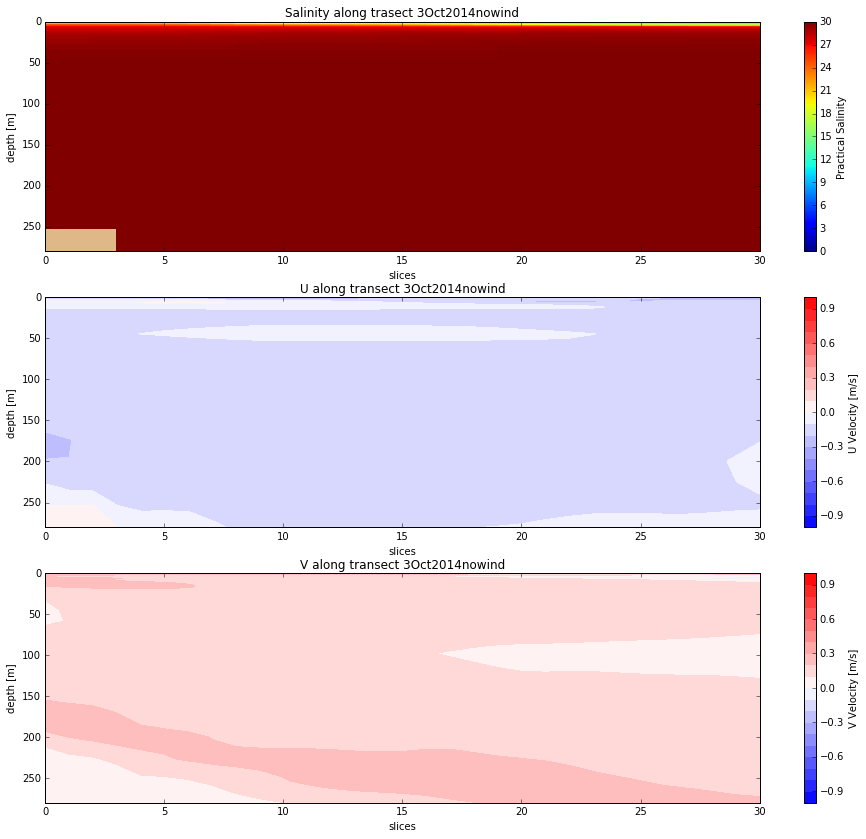

In [21]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','3',33,st = 'middle of flood')

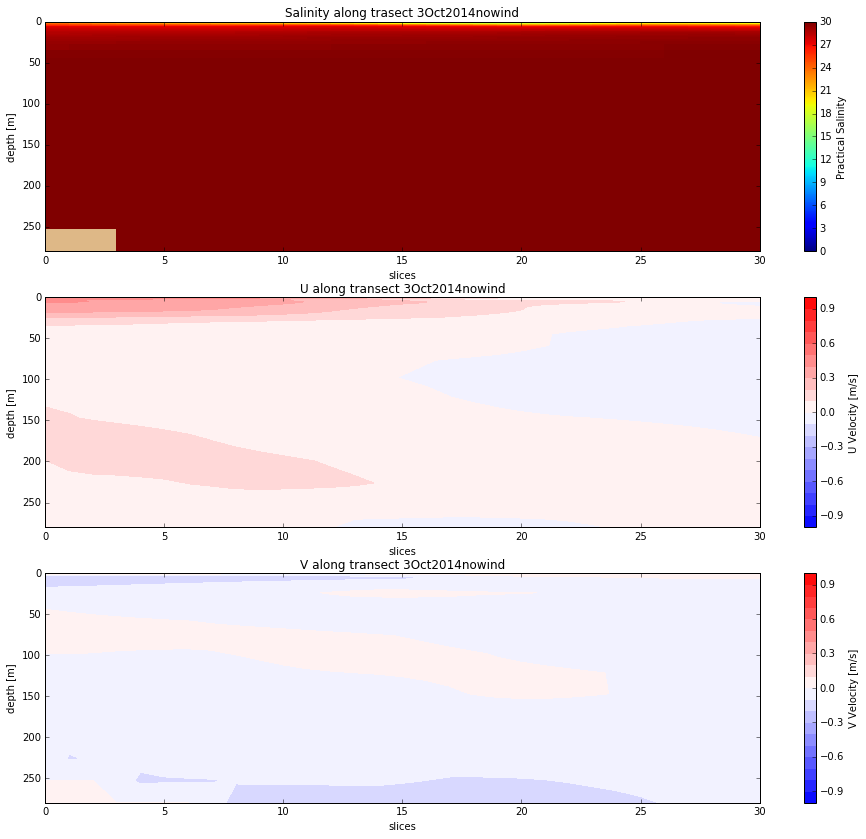

In [22]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','3',33,st = 't_ind_high')

* transect 4

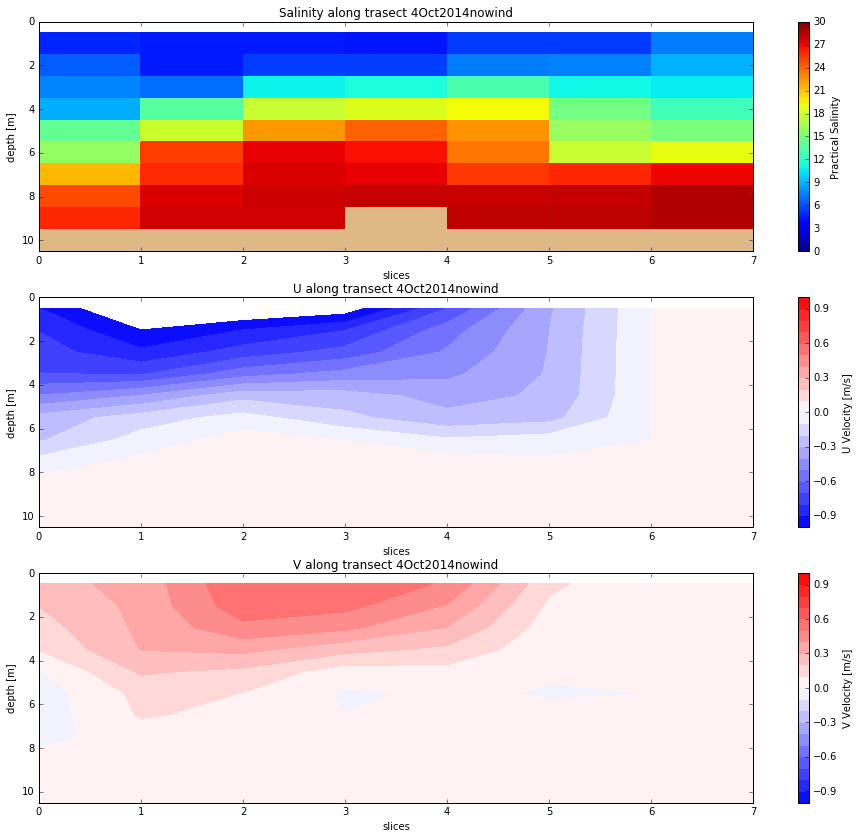

In [23]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','4',10,st = 't_ind_low')

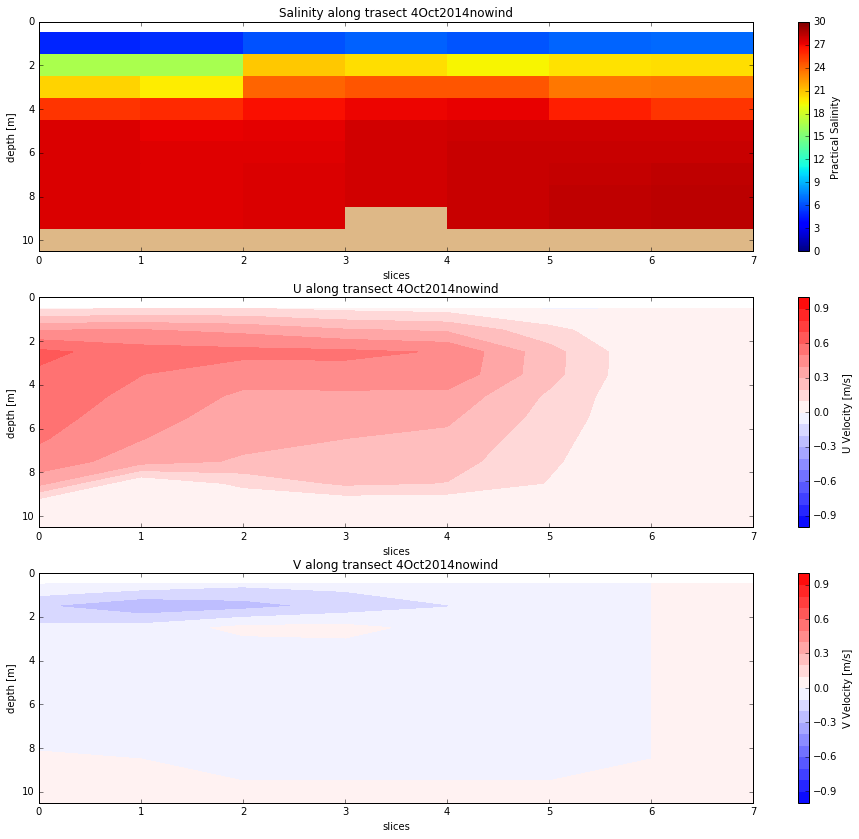

In [24]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','4',10,st = 'middle of flood')

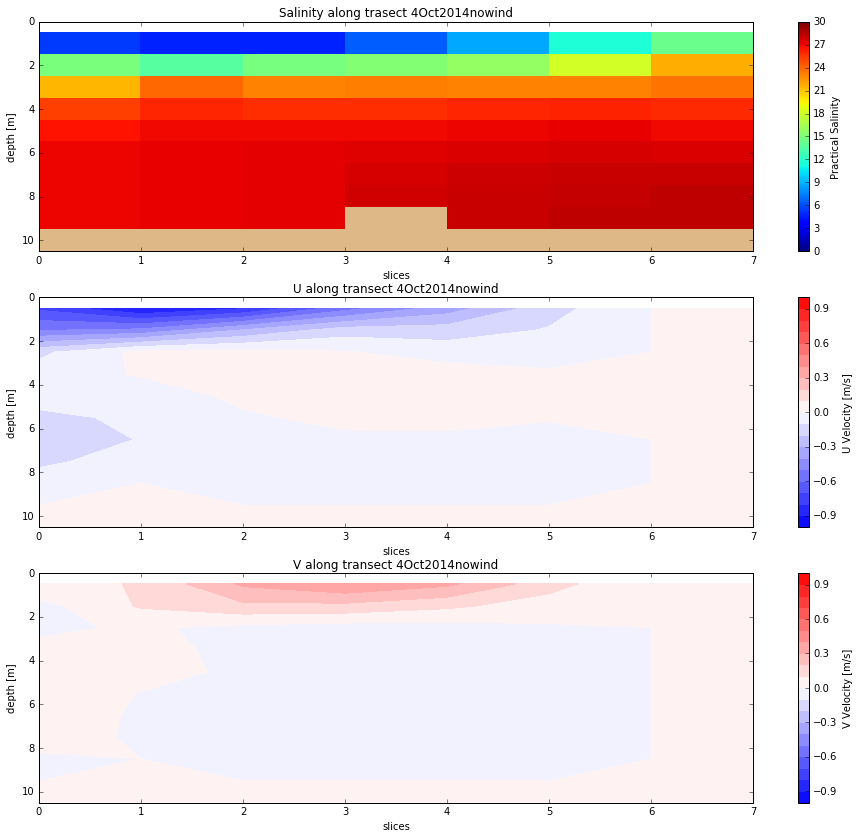

In [25]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','4',10,st = 't_ind_high')

# Nof

* transect 1

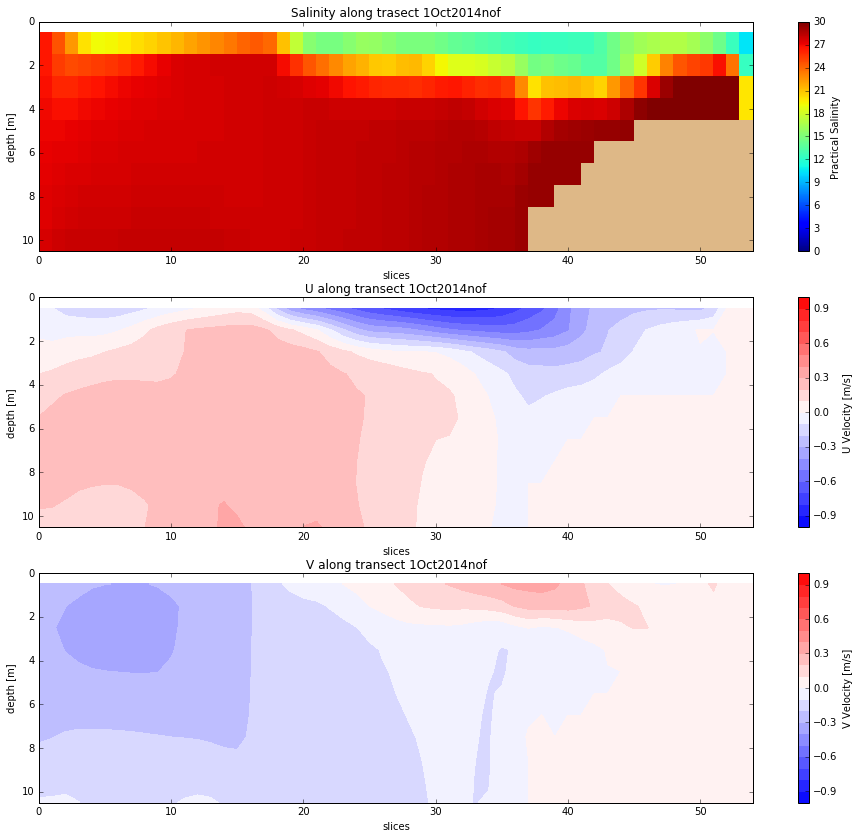

In [26]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','1',10,st = 't_ind_low')

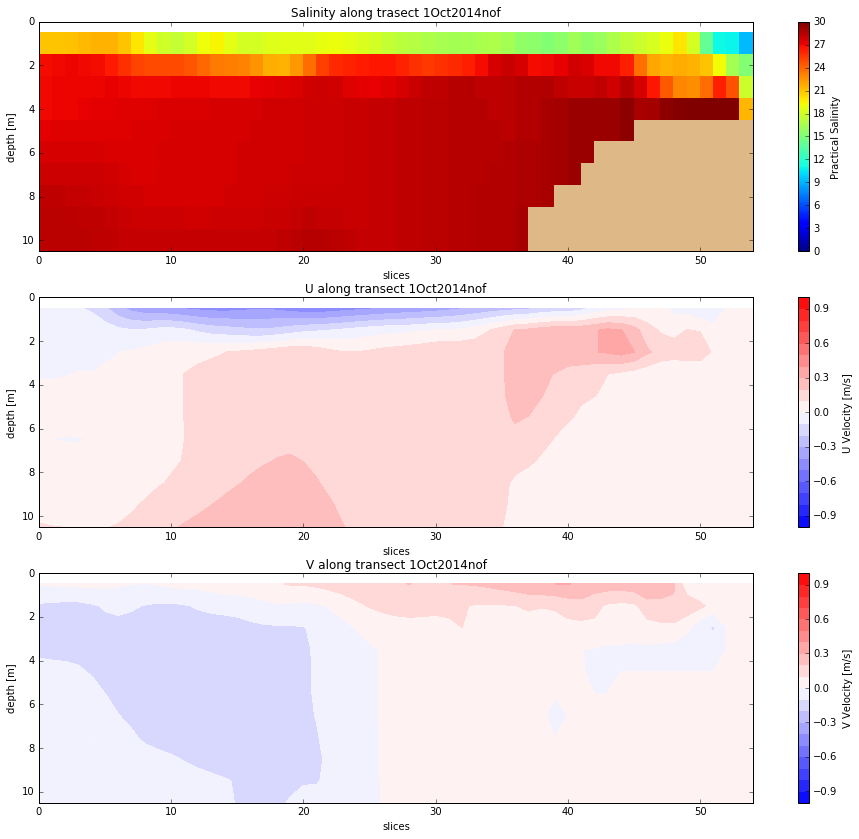

In [27]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','1',10,st = 'middle of flood')

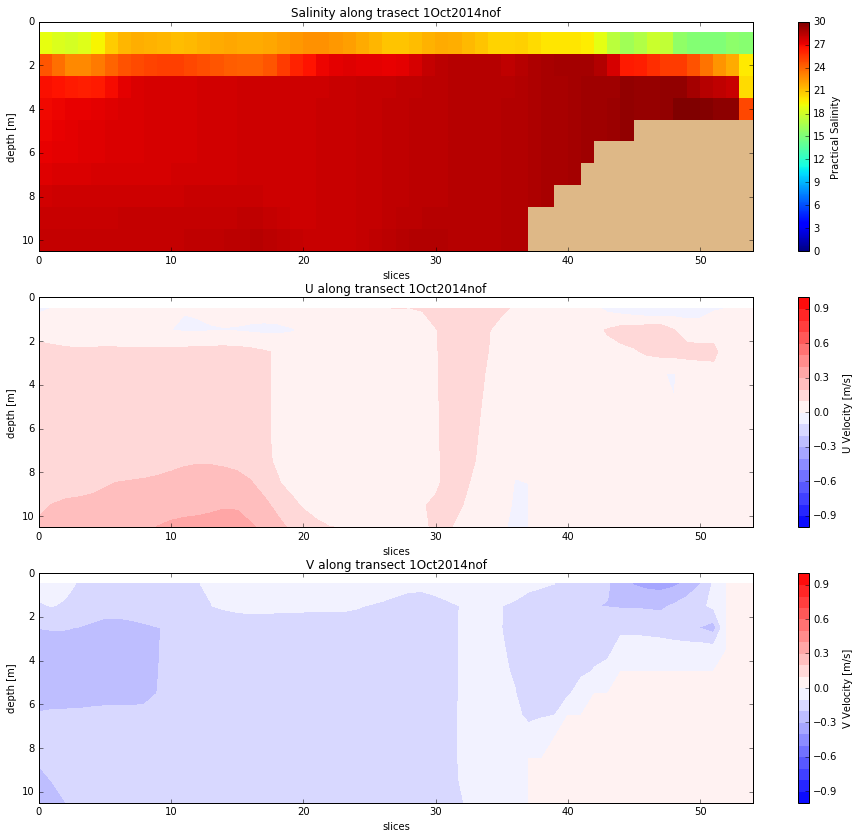

In [28]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','1',10,st = 't_ind_high')

* transect 2

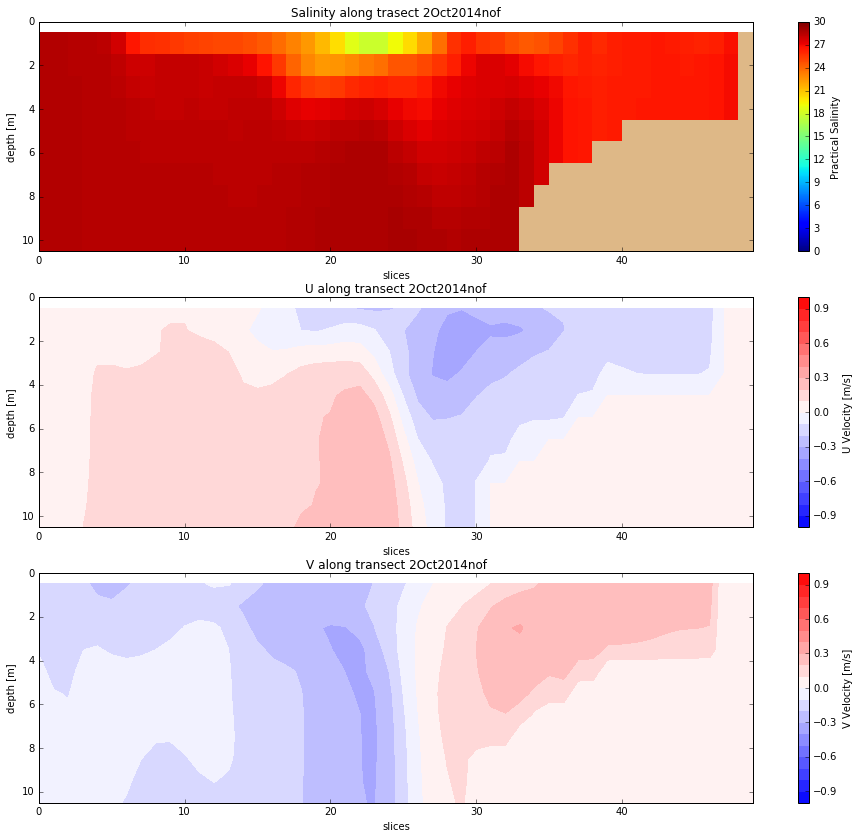

In [29]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','2',10,st = 't_ind_low')

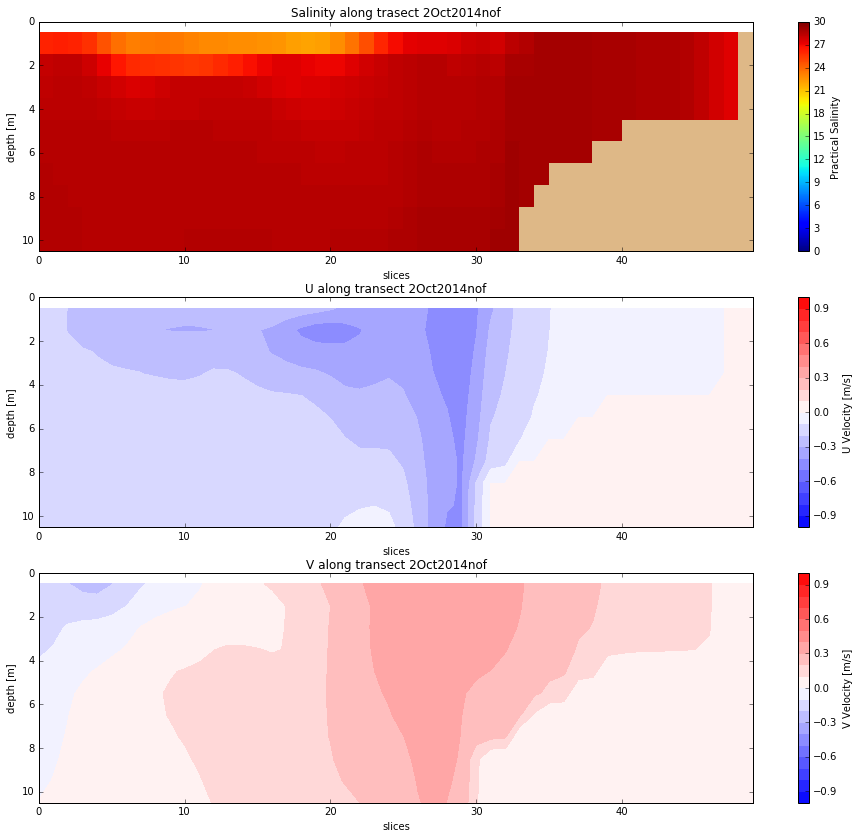

In [30]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','2',10,st = 'middle of flood')

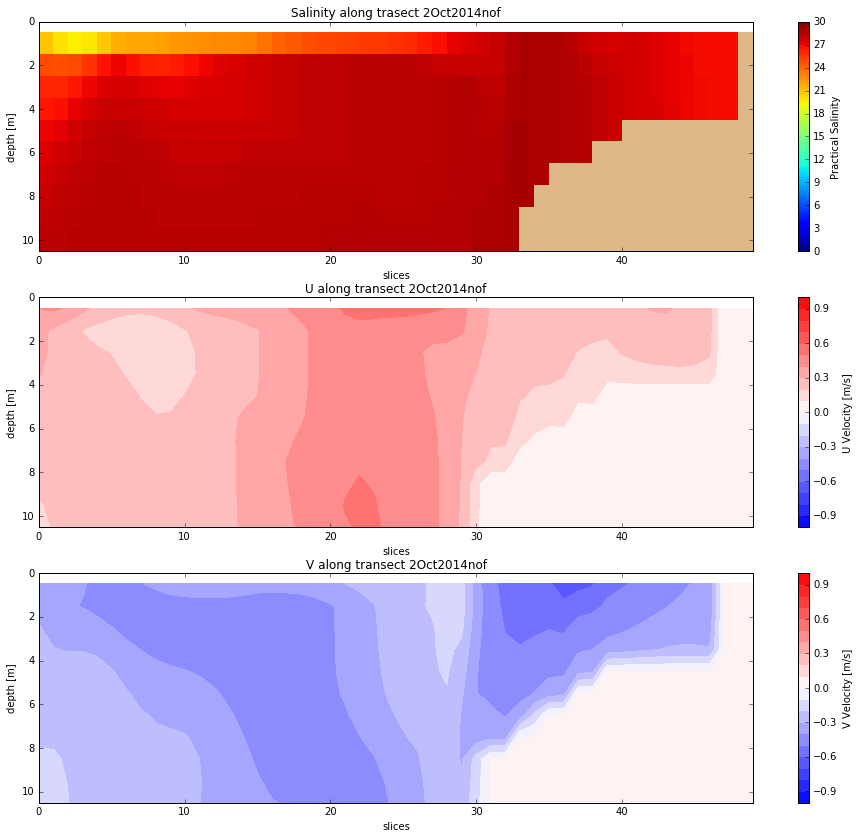

In [31]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','2',10,st = 't_ind_high')

* transect 3

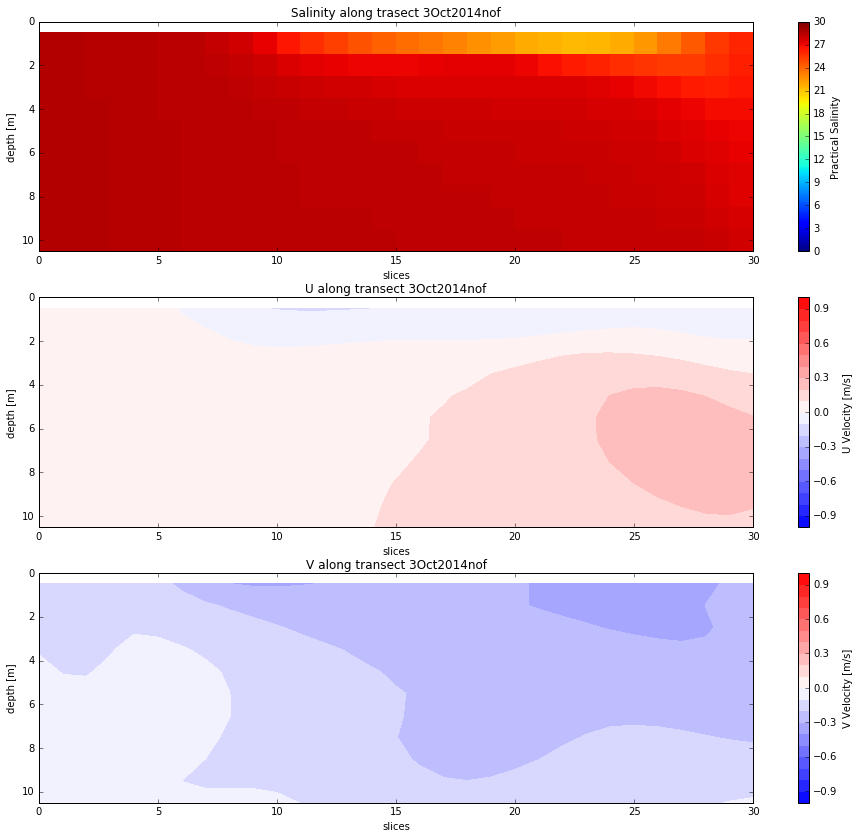

In [32]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','3',10,st = 't_ind_low')

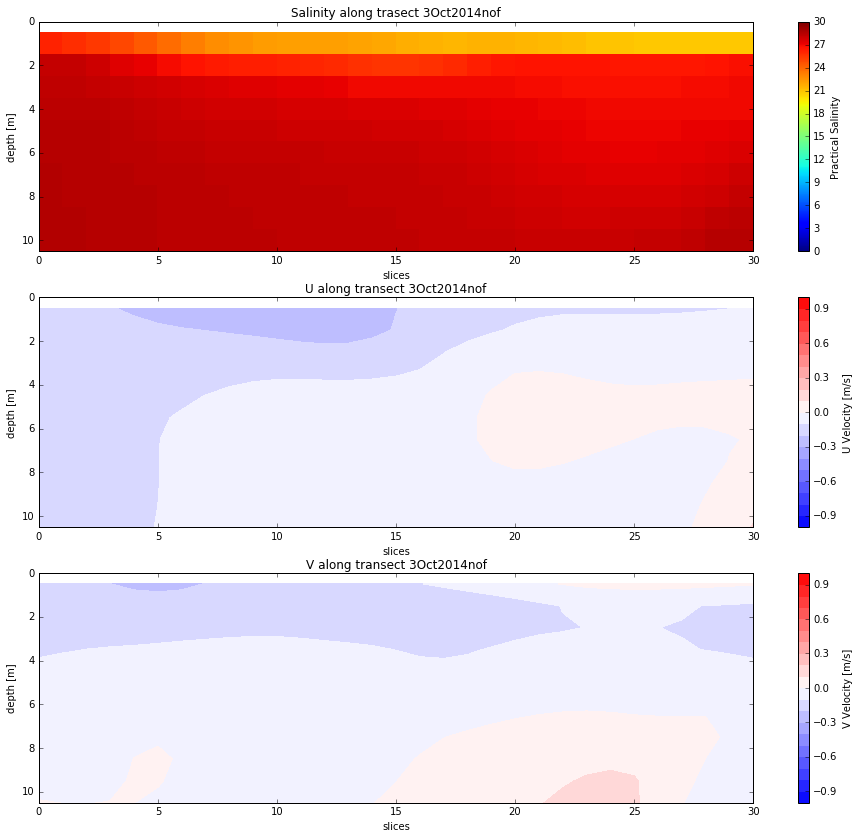

In [33]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','3',10,st = 'middle of flood')

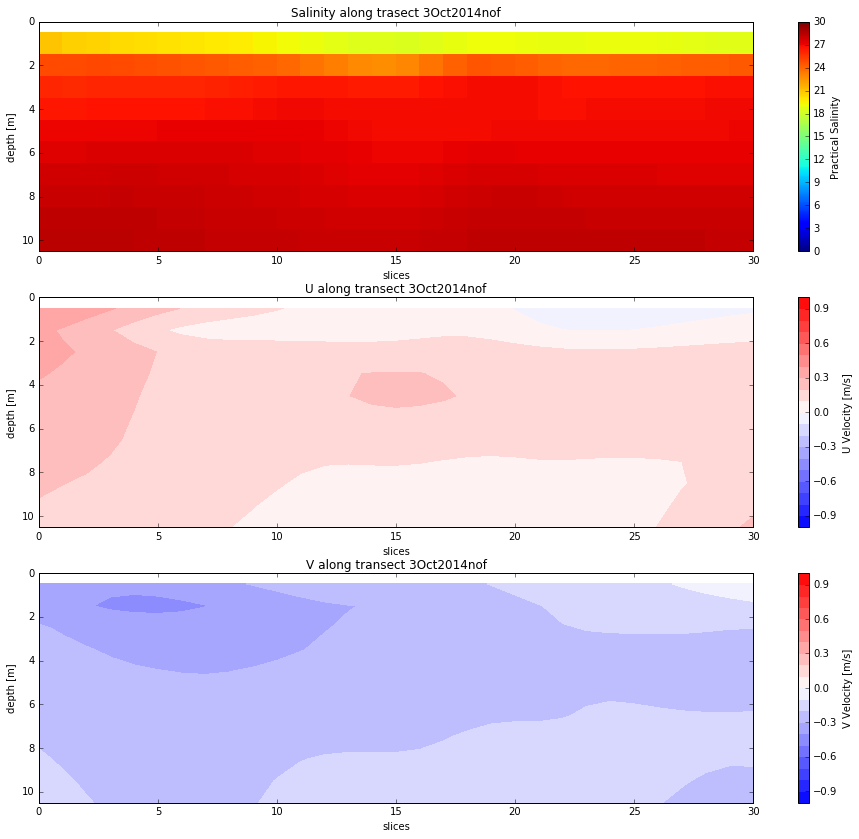

In [34]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','3',10,st = 't_ind_high')

* transect 4

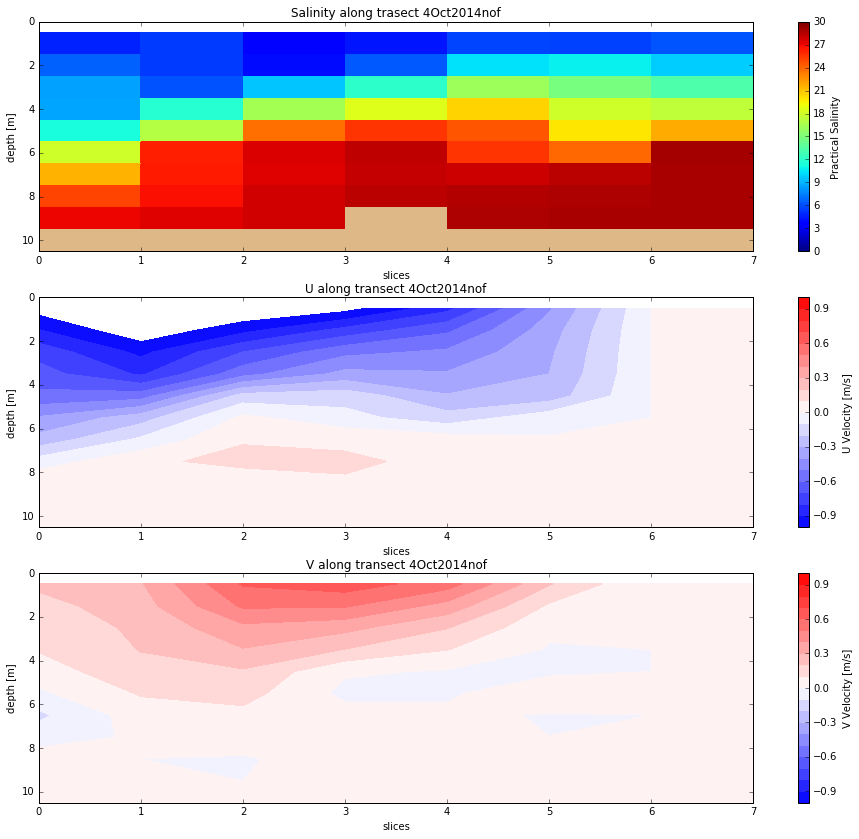

In [35]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','4',10,st = 't_ind_low')

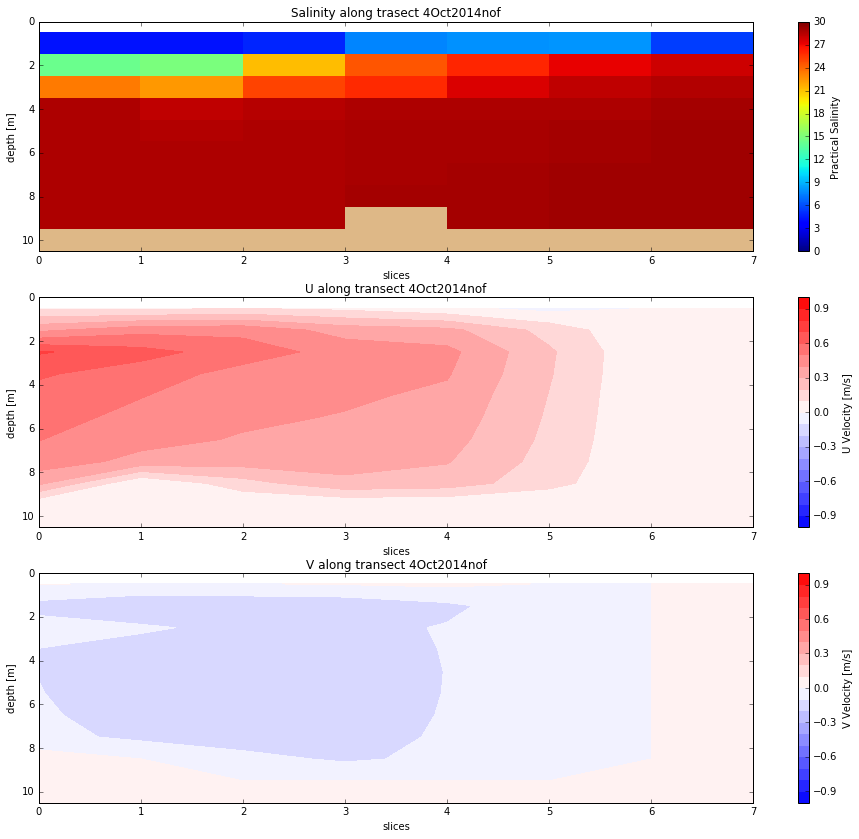

In [36]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','4',10,st = 'middle of flood')

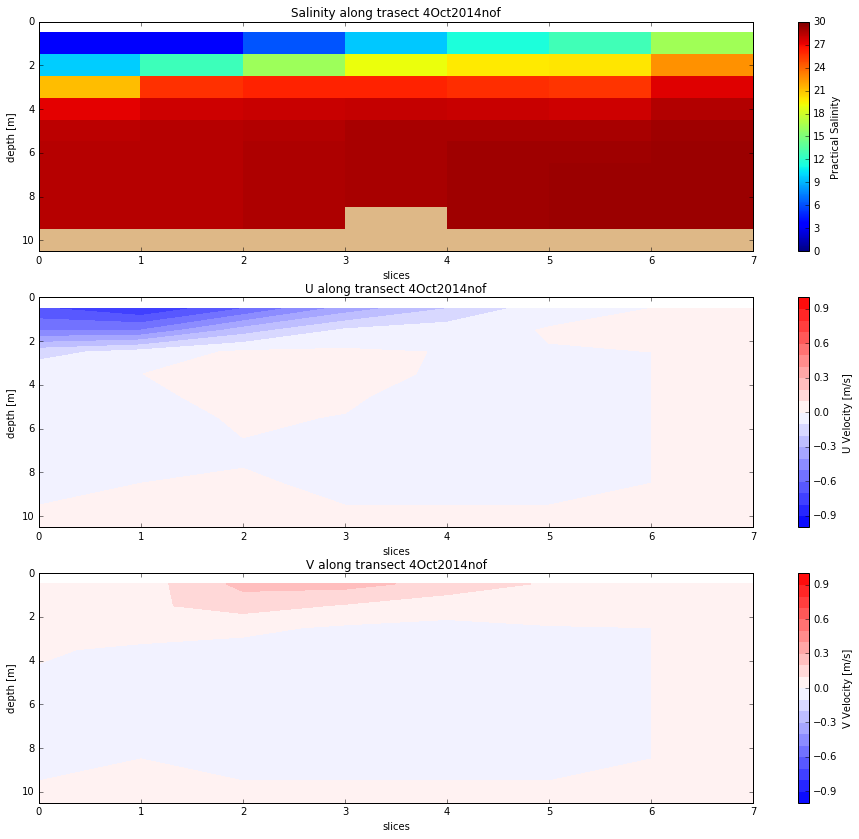

In [37]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','4',10,st = 't_ind_high')

# Combineall

* transect 1

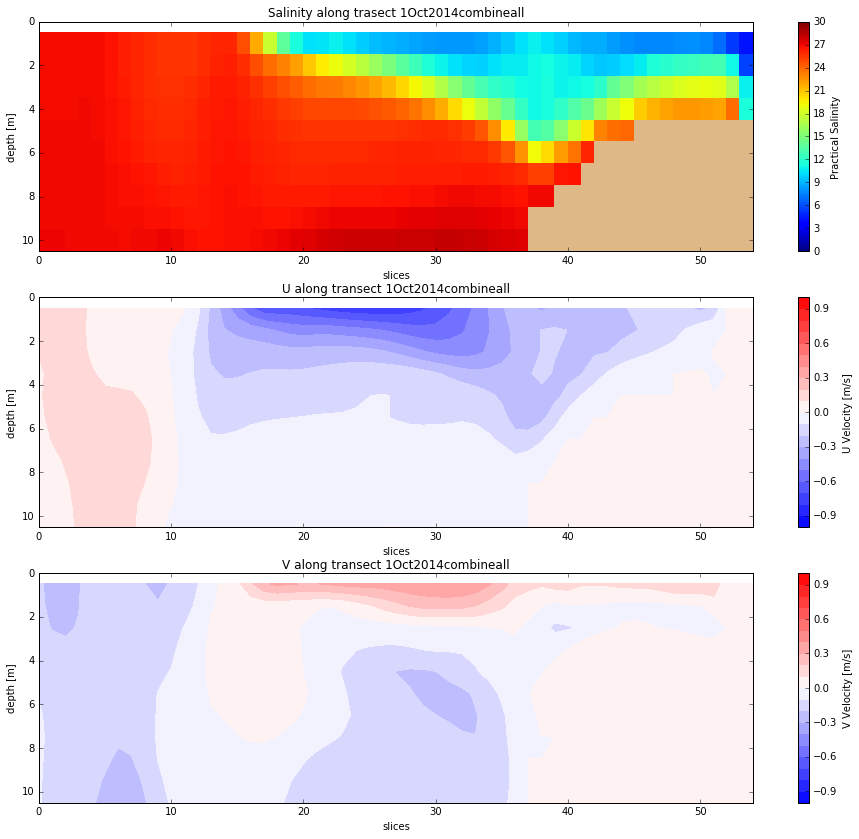

In [38]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','1',10,st = 't_ind_low')

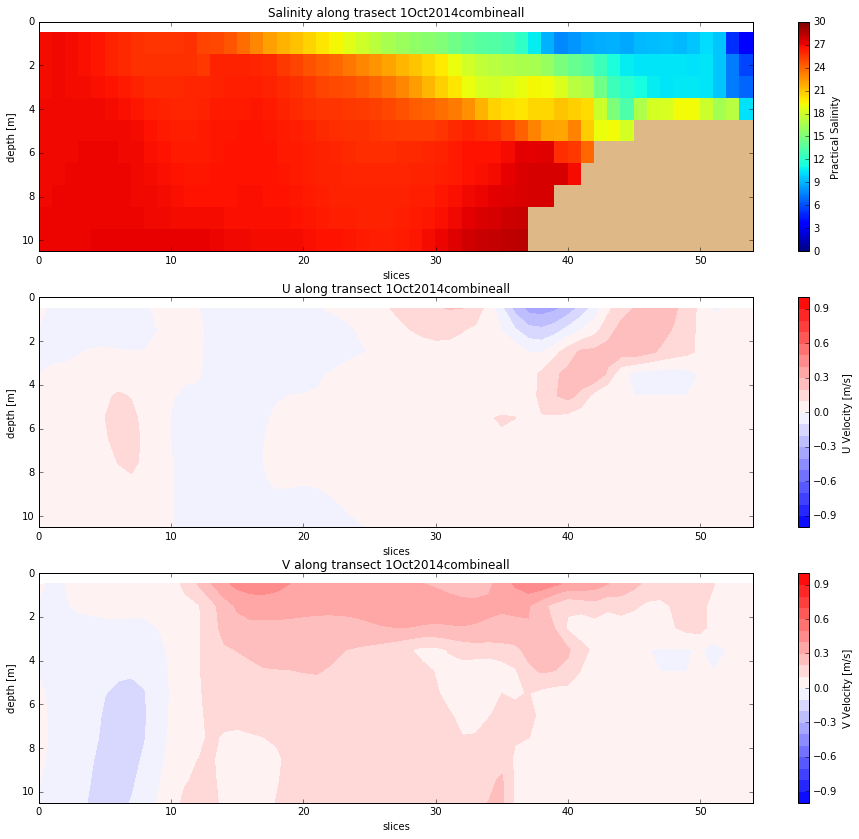

In [39]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','1',10,st = 'middle of flood')

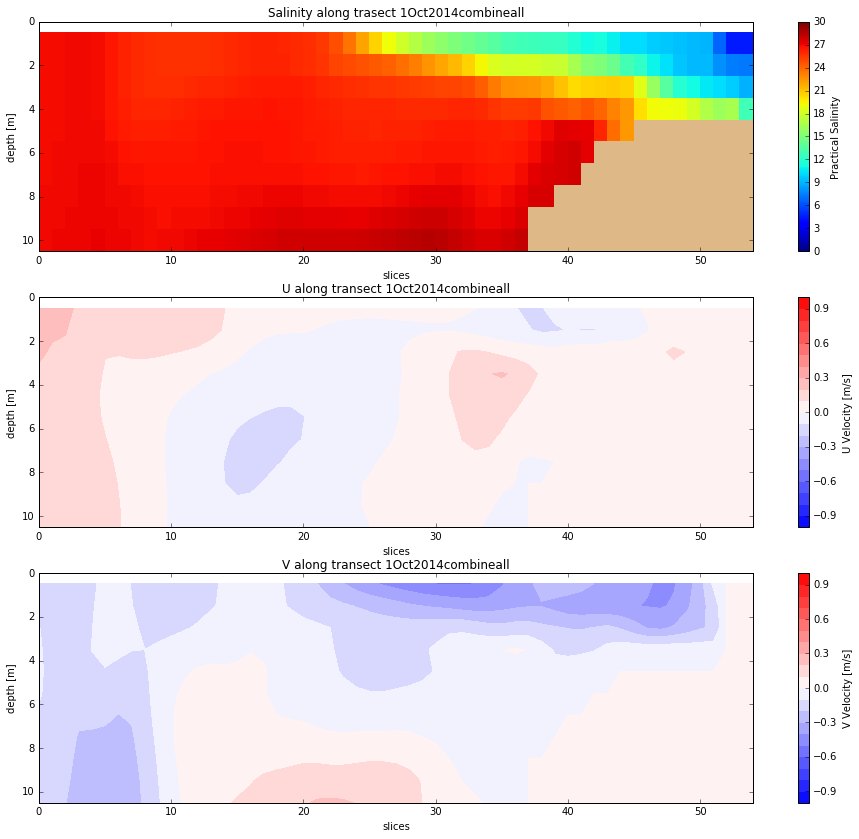

In [40]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','1',10,st = 't_ind_high')

* transect 2

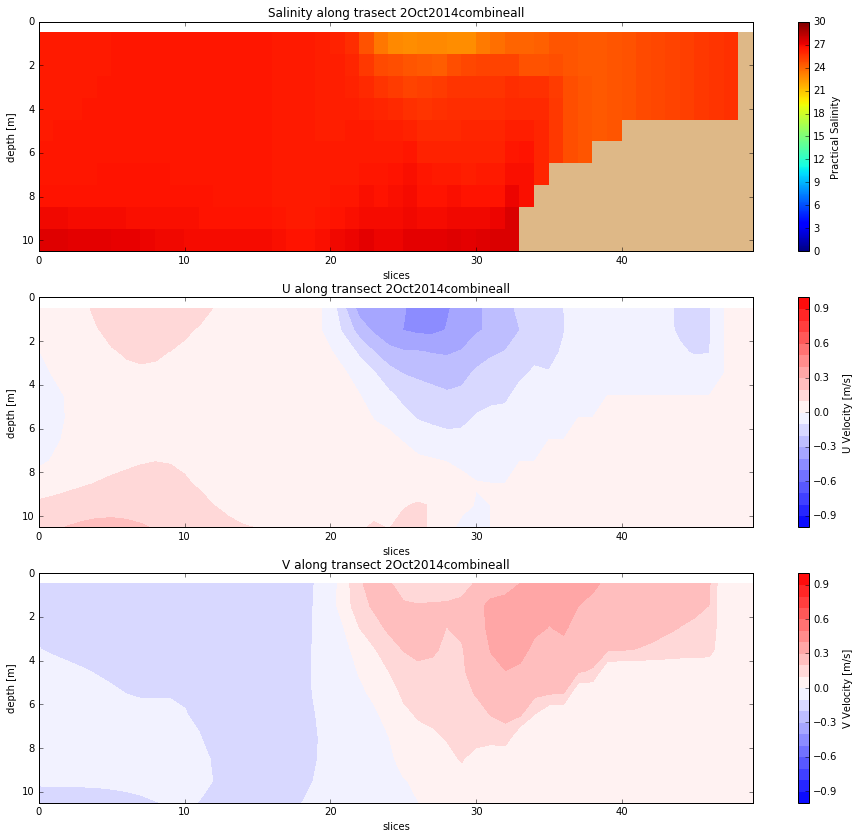

In [41]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','2',10,st = 't_ind_low')

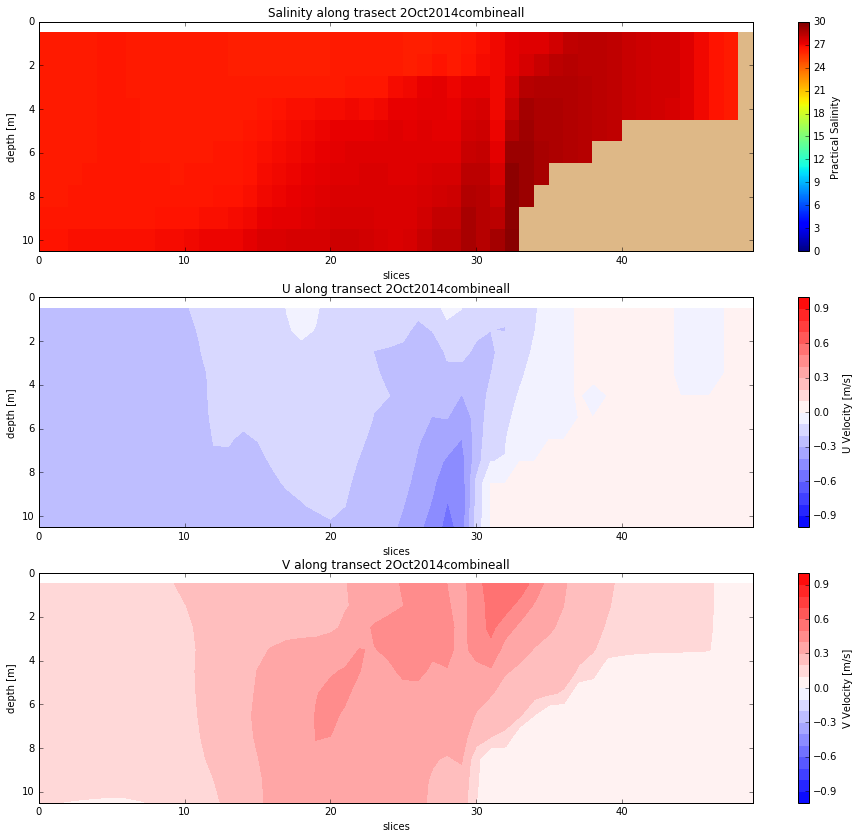

In [42]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','2',10,st = 'middle of flood')

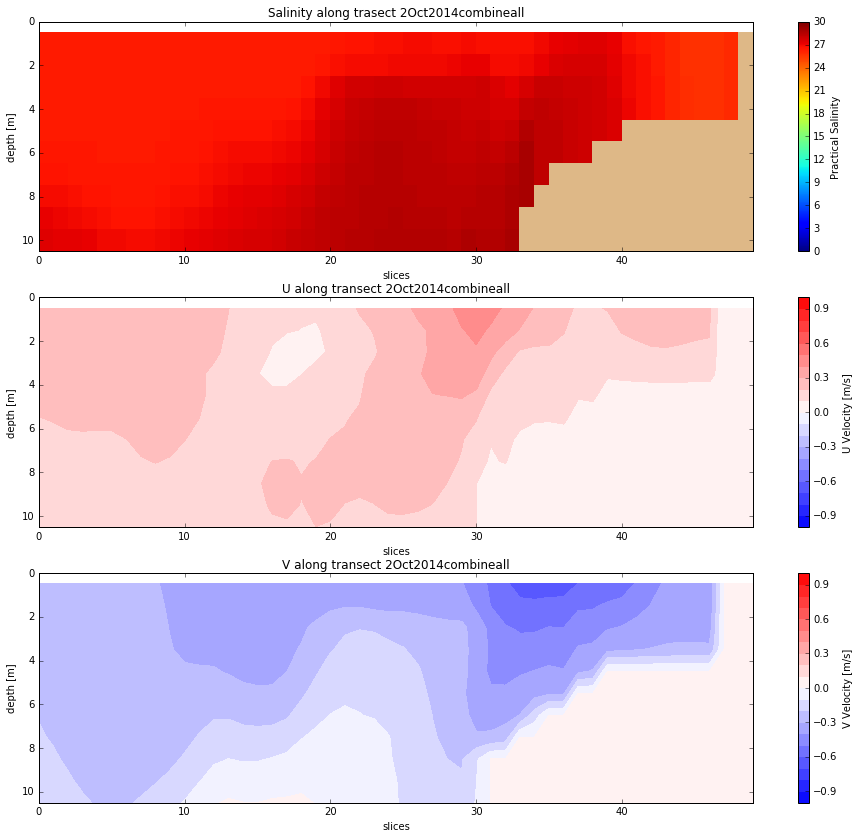

In [43]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','2',10,st = 't_ind_high')

* transect 3

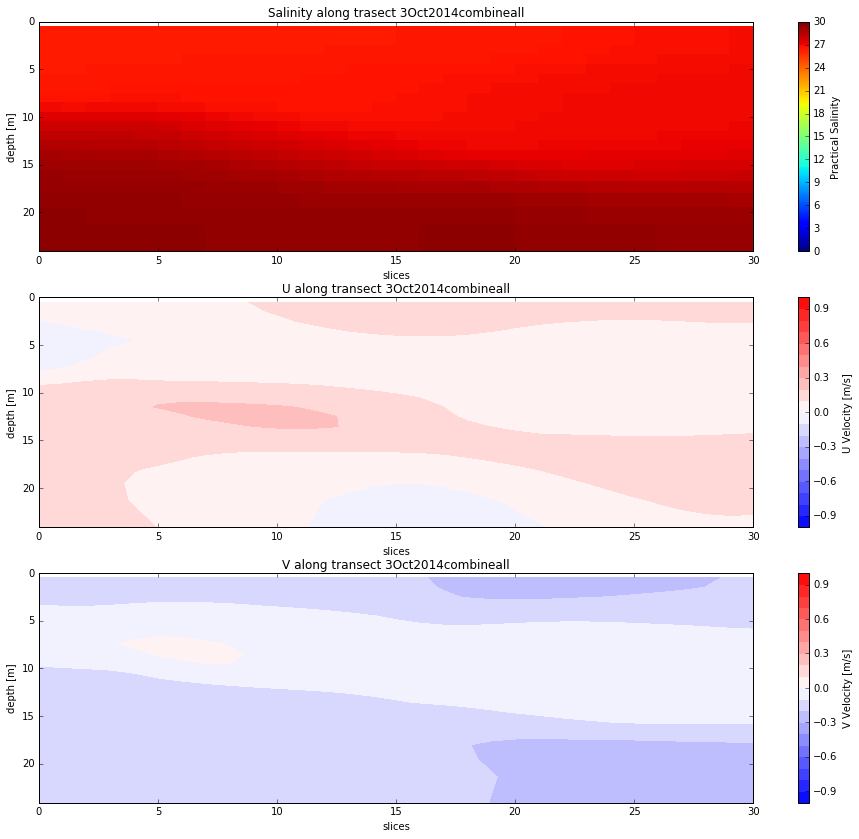

In [44]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','3',20,st = 't_ind_low')

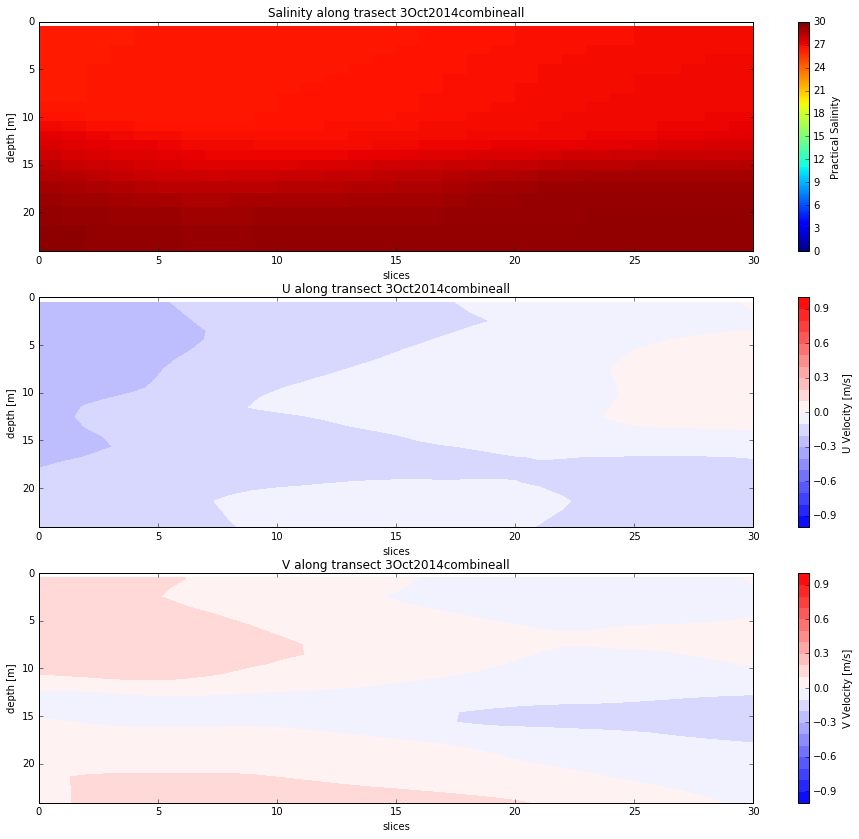

In [45]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','3',20,st = 'middle of flood')

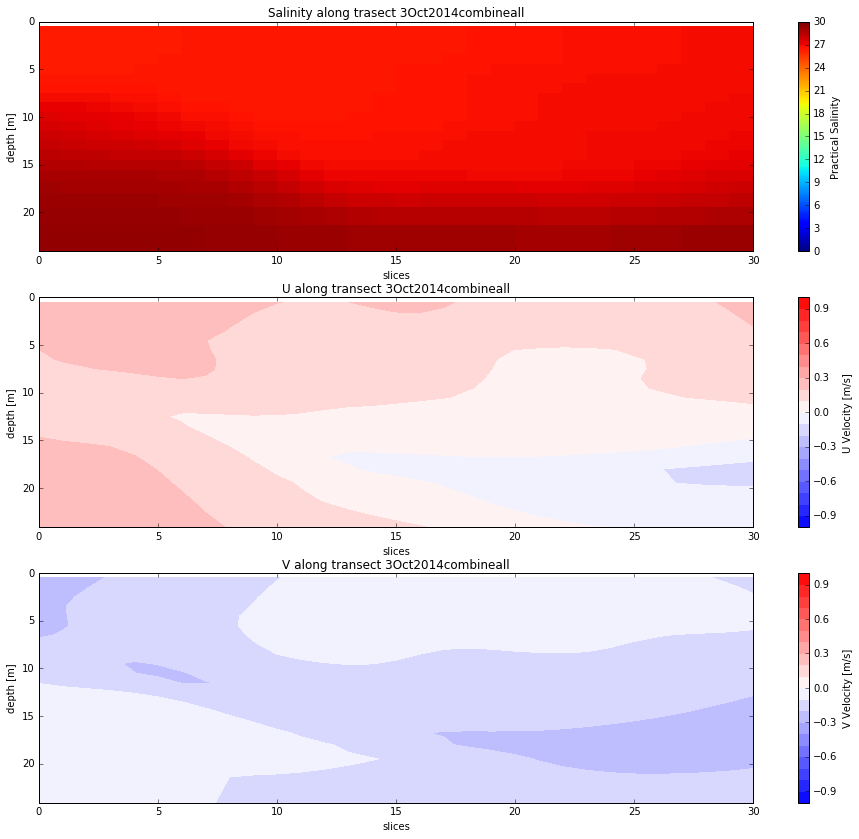

In [46]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','3',20,st = 't_ind_high')

* transect 4

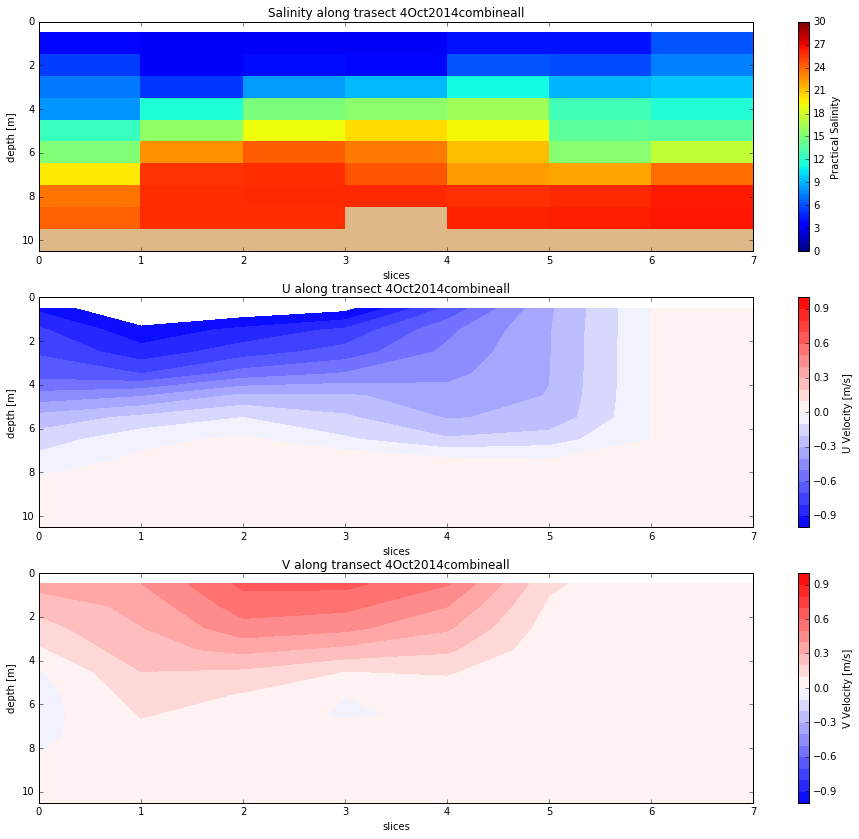

In [47]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','4',10,st = 't_ind_low')

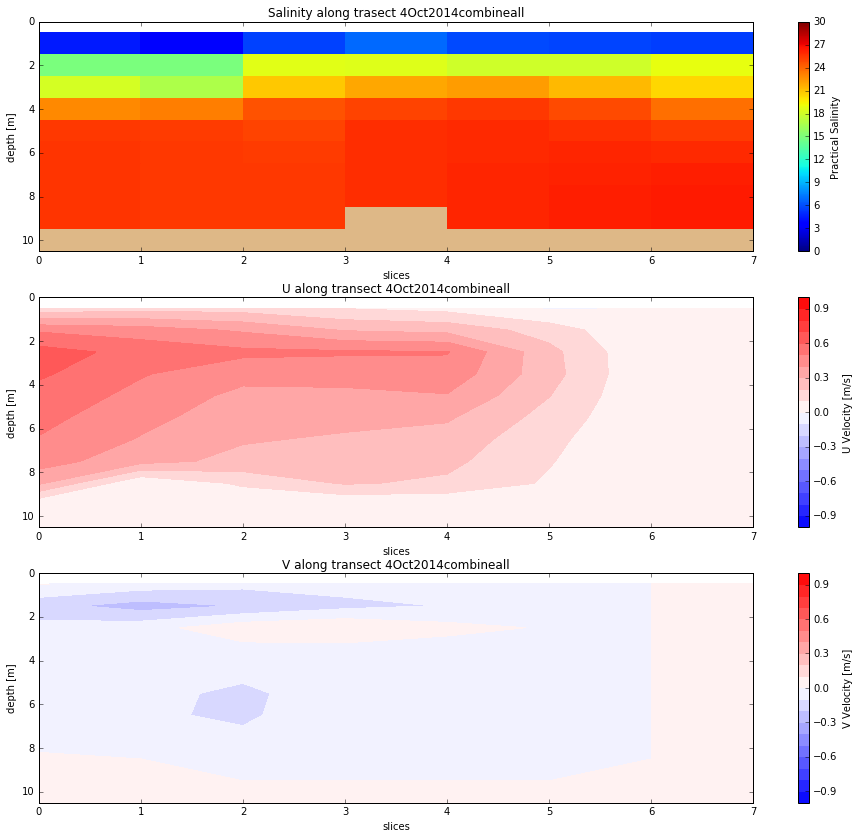

In [48]:
uu = uvs_contour(U,V,S,depU,depV,'Oct2014combineall','4',10,st = 'middle of flood')

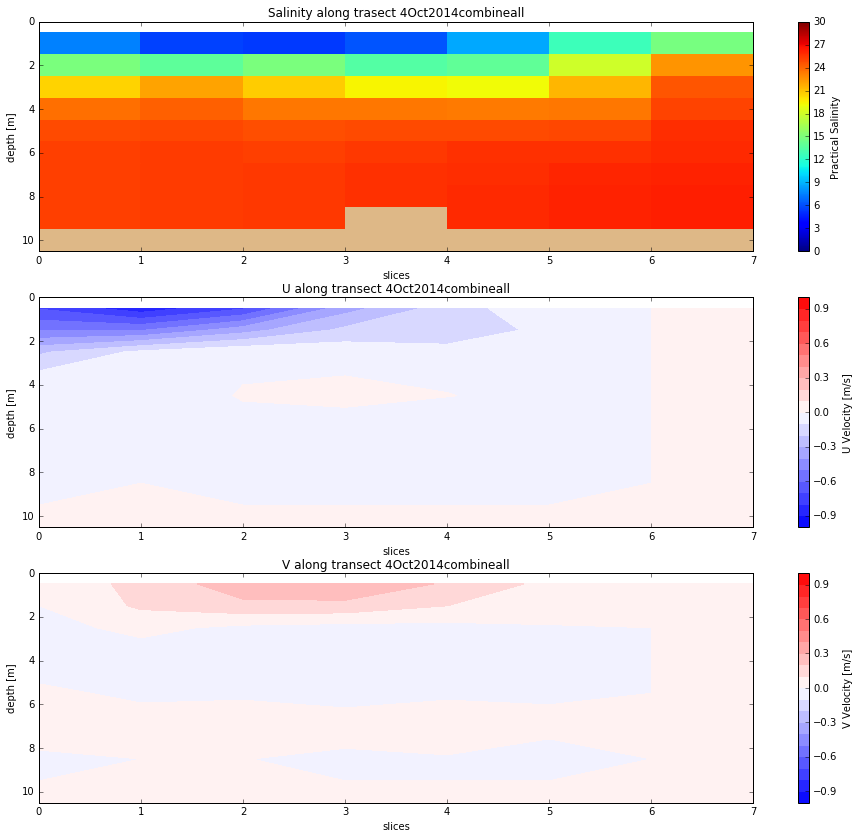

In [49]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','4',10,st = 't_ind_high')

# Total transport

Oct2014OnlyRiver [40864.359631849853, 40328.814125891804, 40139.568745537123]
Oct2014notides [24384.448994255858, 32003.474333794511, 28471.917885027753]
Oct2014nowind [-80474.555085504631, 530372.26198422699, 1533.9869897475601]
Oct2014nof [-107982.97598152456, 477162.09505464014, -136911.28905215446]
Oct2014combineall [-79119.950803284722, 548105.23250364629, 23793.504856752024]


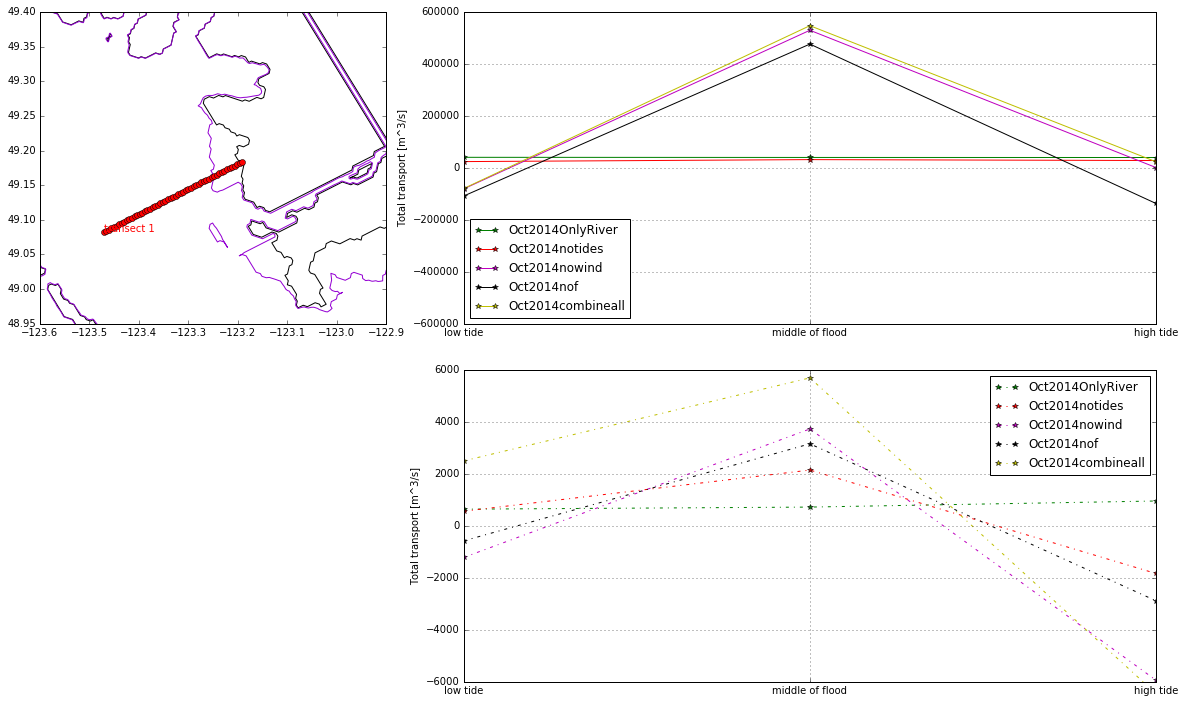

In [12]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'1')

Oct2014OnlyRiver [1693.3561551934108, 1604.3201943555759, 1652.5976530515327]
Oct2014notides [42984.907985036363, 40496.835533700112, 33038.376530873691]
Oct2014nowind [-30791.199820746206, 502005.79017738457, 53742.016018343405]
Oct2014nof [-65728.642309593663, 439091.37664712092, -112381.8968755891]
Oct2014combineall [-28345.997047932546, 525414.23281870736, 87033.566222557638]


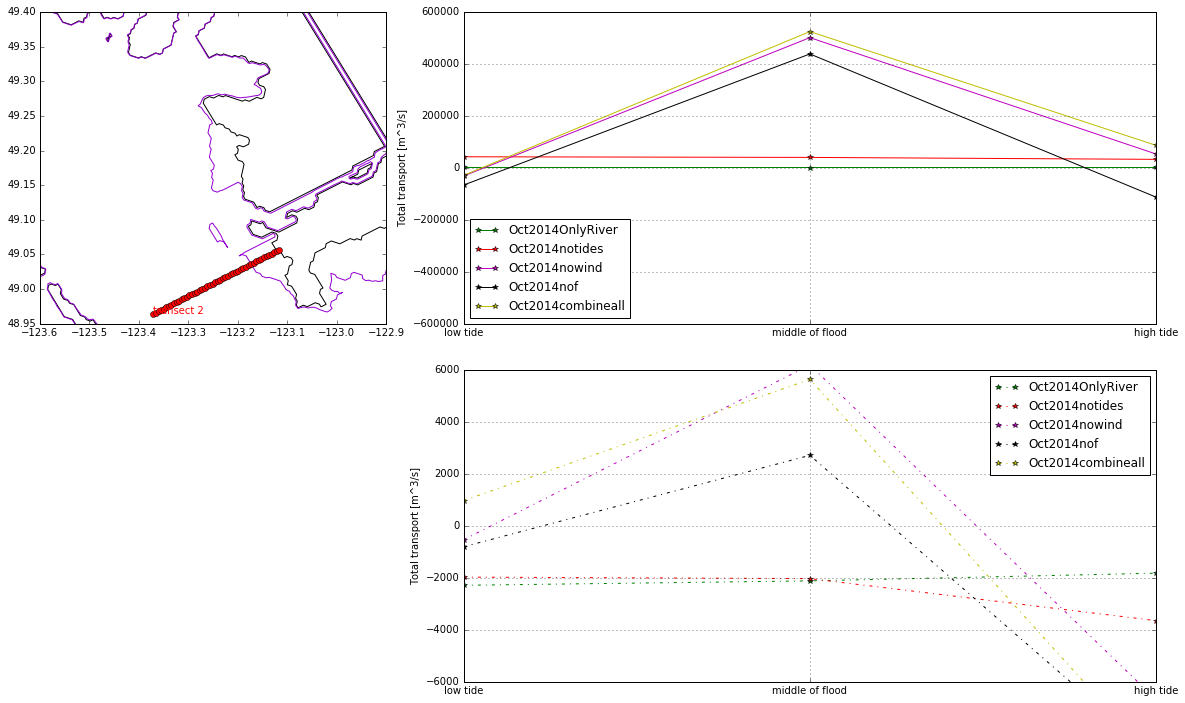

In [13]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'2')

Oct2014OnlyRiver [83052.927051407125, 83505.674373280403, 83467.155209626173]
Oct2014notides [84337.419821145697, 60242.746533811805, 55964.56788175564]
Oct2014nowind [79969.656817428069, -587539.55230164691, 209528.97661147401]
Oct2014nof [12090.921855712062, -749661.48027312034, -17967.230319049799]
Oct2014combineall [75950.399219951272, -599069.50289784069, 203995.71508886301]


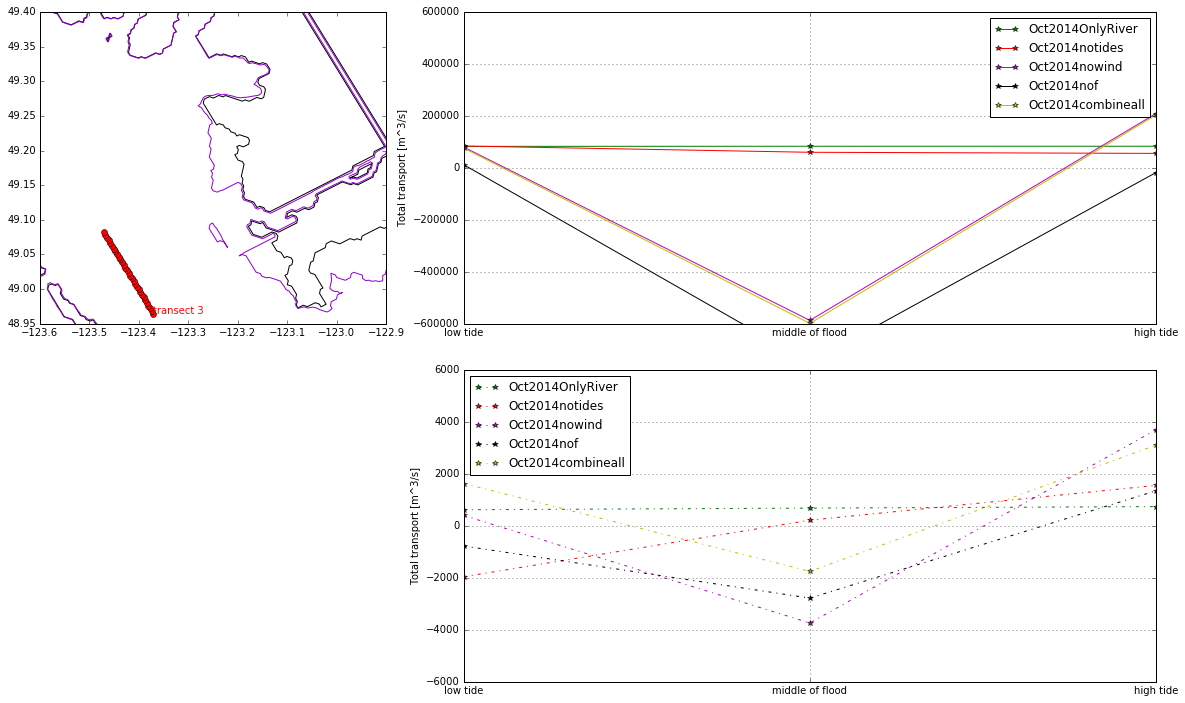

In [14]:
fig= transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'3')

* No wind case does not affect much on the total water transport in the water column of the plume region, more important for downstream surface transport than upstream.
* Total transport at north/south transect of onlyriver/notide case is always upstream, with surface transport going north and south for each transect (north/south), respectively.

Oct2014OnlyRiver [-3212.5401492790879, -3156.6896431528453, -3194.1228444766725]
Oct2014notides [-3623.2120584929694, -3566.2078911646695, -3374.3626648109876]
Oct2014nowind [-8250.1394708543157, 8730.5565819388248, -3543.9697051734202]
Oct2014nof [-8109.8739211074972, 9386.4886497095176, -2790.0167144207066]
Oct2014combineall [-8336.2164521284431, 8821.111218654034, -3689.3789268930286]


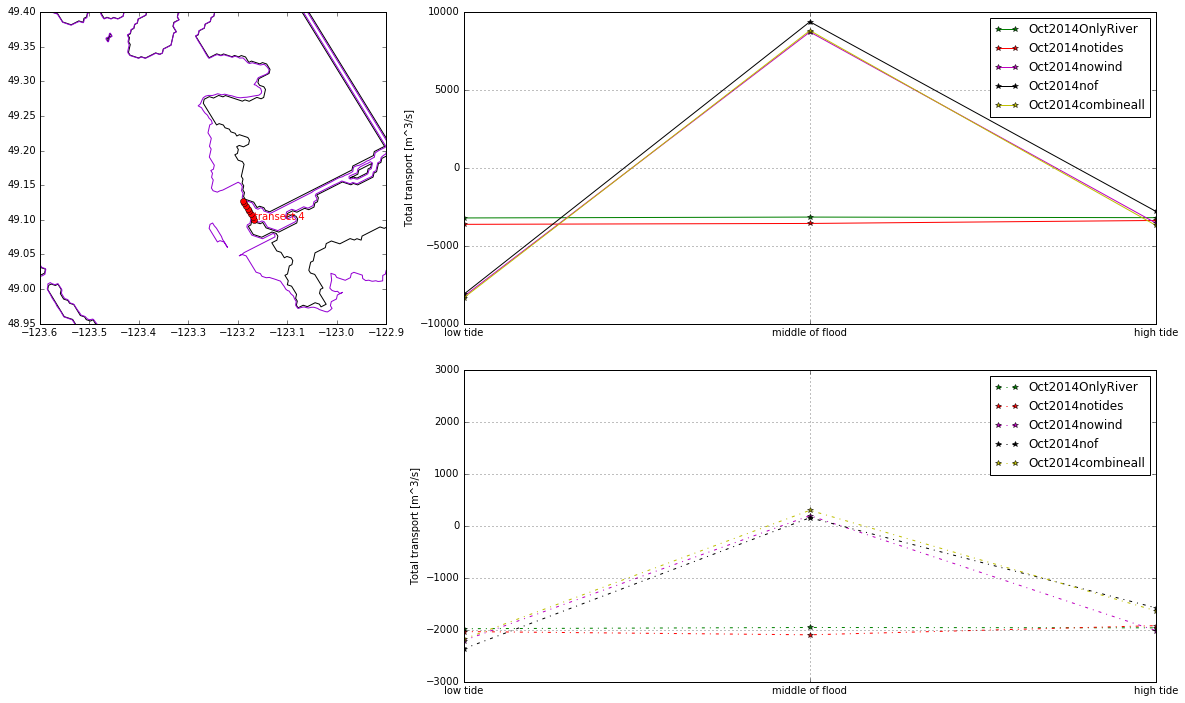

In [15]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',y0lim=1e4,y1lim=3e3)

# fresh water transport

Oct2014OnlyRiver [-11653.22729098168, -11515.915002782362, -11353.146493871191]
Oct2014notides [-14147.005807605805, -13512.128867919153, -17237.11060148164]
Oct2014nowind [-4817.4773525752216, 436.67396287853899, -7198.4030366240058]
Oct2014nof [-2218.9860644492278, -10486.34976030671, -4082.8906565290335]
Oct2014combineall [119.58823351652148, -1939.4615946345384, -7930.6031561462223]


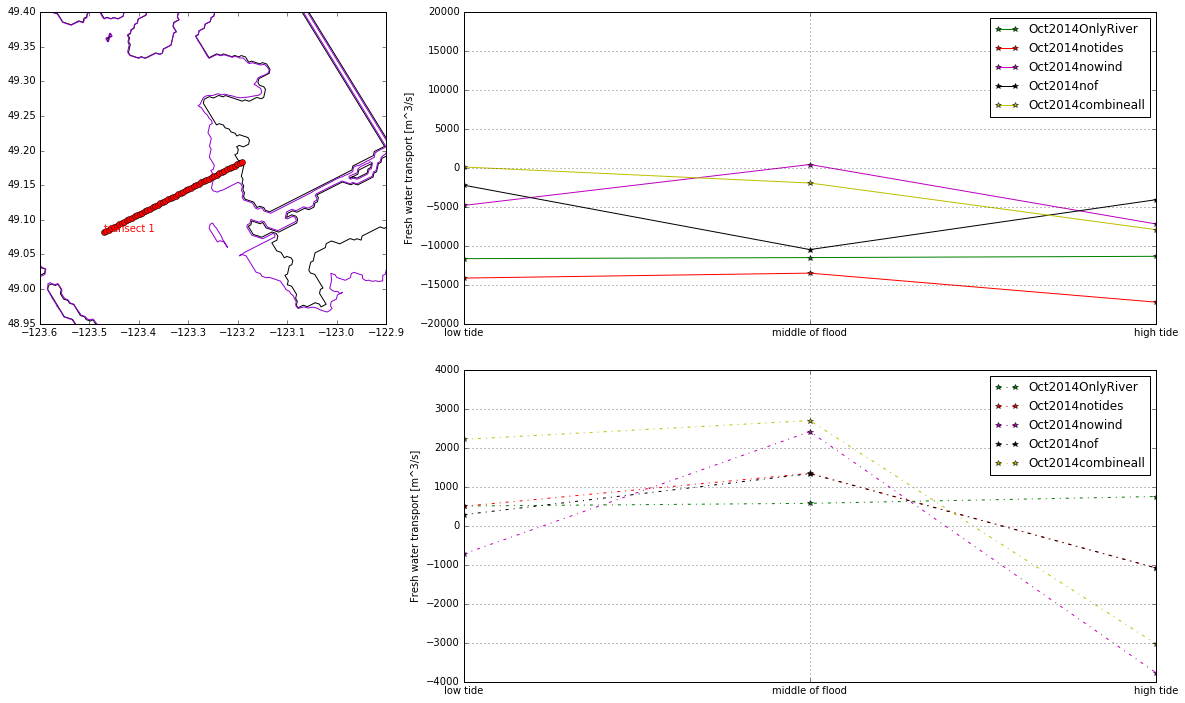

In [16]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'1',fresh_flag = True, y0lim =2e4,y1lim = 4e3)

Oct2014OnlyRiver [-12437.16251124426, -12242.813109880095, -11944.735420257019]
Oct2014notides [-11254.272783065333, -11413.254874297269, -12168.942506120737]
Oct2014nowind [-2849.942751991357, 3754.5003904978503, -5249.2093468926068]
Oct2014nof [-1189.2010304501794, -5643.2263842691009, -8109.3683344511801]
Oct2014combineall [105.97751753072848, -217.19198340369985, -6248.4676749675418]


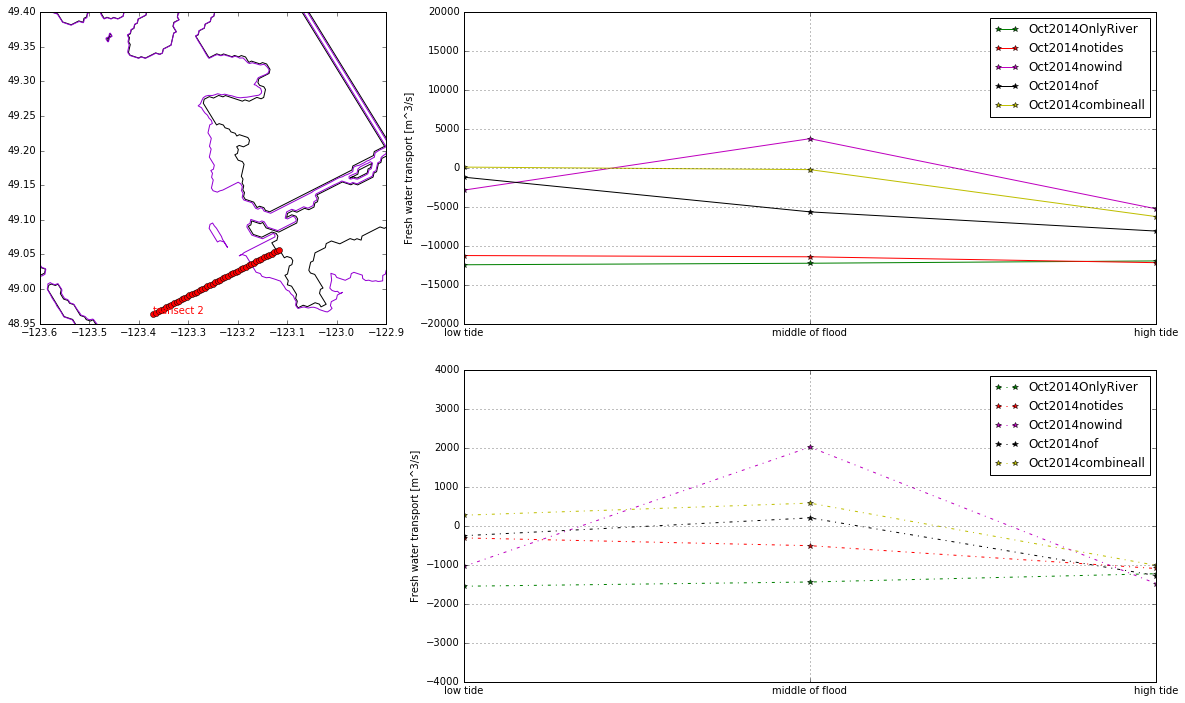

In [17]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'2',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

In [18]:
# get Fraser Flow data
filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
fraserflow = np.loadtxt(filename)
fraserflow[378]

array([ 2014.   ,    10.   ,    31.   ,  2585.685])

Oct2014OnlyRiver [-12437.16251124426, -12242.813109880095, -11944.735420257019]
Oct2014notides [-11254.272783065333, -11413.254874297269, -12168.942506120737]
Oct2014nowind [-2849.942751991357, 3754.5003904978503, -5249.2093468926068]
Oct2014nof [-1189.2010304501794, -5643.2263842691009, -8109.3683344511801]
Oct2014combineall [105.97751753072848, -217.19198340369985, -6248.4676749675418]


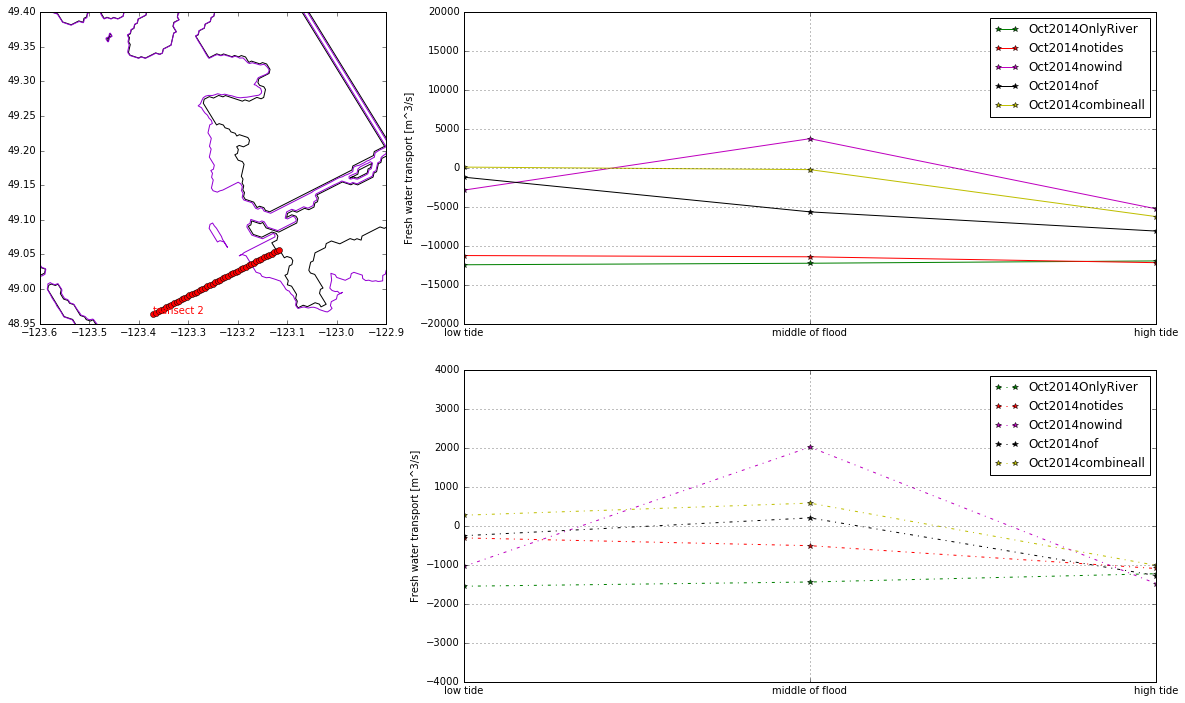

In [19]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'2',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

Oct2014OnlyRiver [372.5487580914845, 314.21275926363364, 293.3488570217653]
Oct2014notides [-773.59441445233415, 1127.0208049391169, 1077.1295709171477]
Oct2014nowind [777.92311685710297, 2218.8779110218593, 5329.3533425345358]
Oct2014nof [2146.9691089445055, 15216.974027277454, 4197.7784791673394]
Oct2014combineall [1647.6897654944185, 7136.980136090051, 2051.7114669515004]


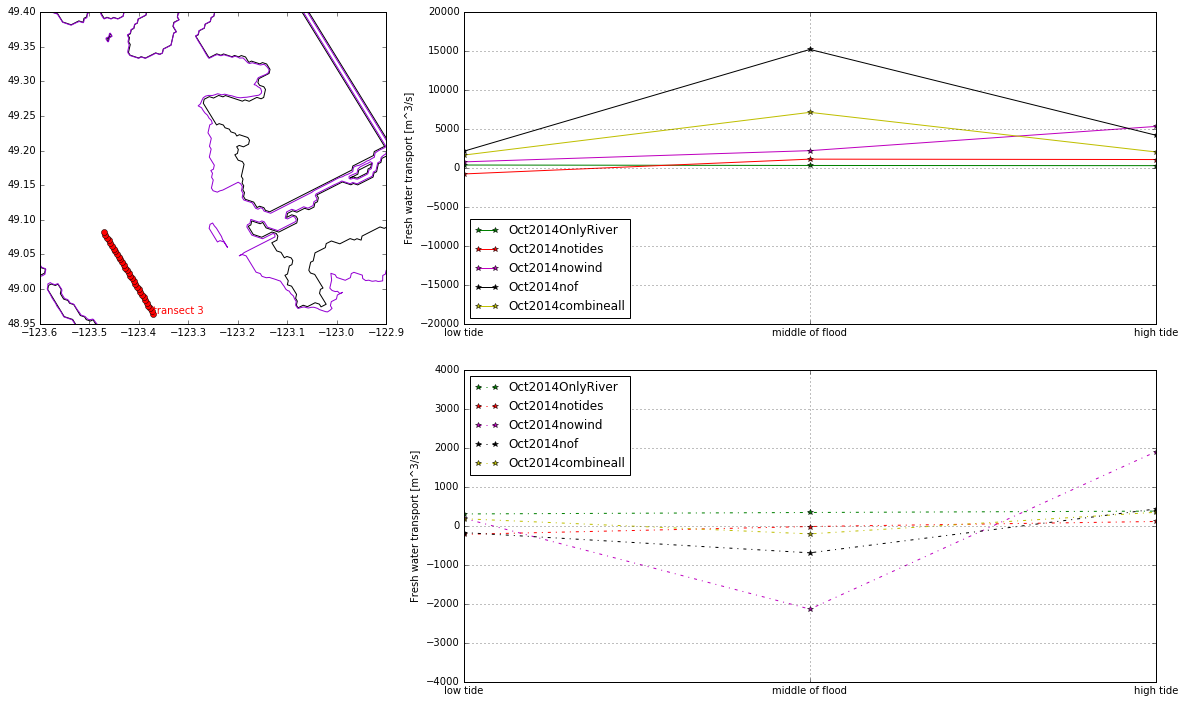

In [20]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'3',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

Oct2014OnlyRiver [-3107.8727237793209, -3088.237398119807, -3060.8542719183242]
Oct2014notides [-3162.3910052473775, -3235.846408586387, -3079.1245634582901]
Oct2014nowind [-5540.0848133871586, 1409.8175777455085, -2172.4669073767636]
Oct2014nof [-5613.8057601523842, 1008.8264170070366, -1771.8572158889938]
Oct2014combineall [-5963.1189760948528, 2129.1618294289774, -2009.7260870045154]


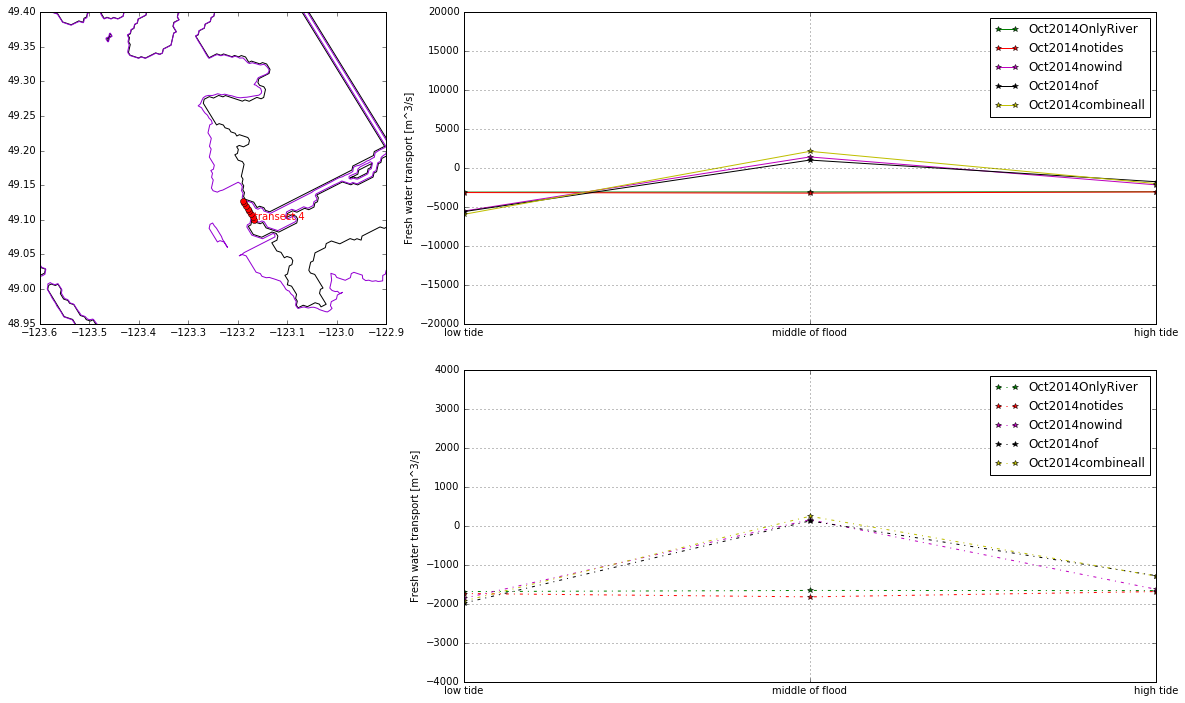

In [21]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

* Tidal cycle at the river mouth, making river discharge pausing with tides. For onlyriver/notides cases, shear flow still exists in at the transect, with surface layer going northwest, lower layer going eastward into the river.
* Actual flood tide (currents going out of the river) period is very short compared with ebb tide period, magnitude of currents flowing into the river peaks at middle of flood tide and return back at high tide.

In [ ]:
trans,trans_sur,trans_to,vv = transport_calculate_general(S,U,V,ssh,lon,lat,depU,depV,'1',730,743)

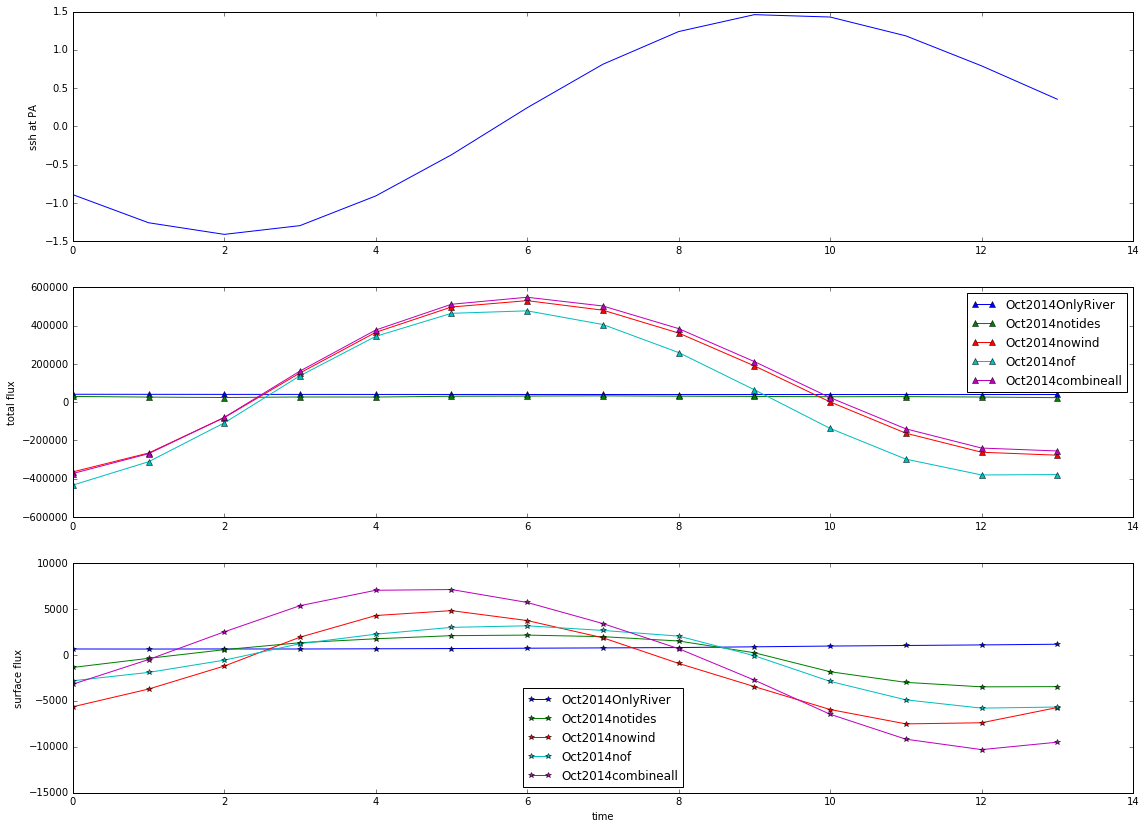

In [40]:
fig, axs = plt.subplots(3,1,figsize = (19,14))
ax = axs[0]
pa = paths[-1]
ax.plot(ssh[pa][730:744,86,89],label= pa)
ax.set_ylabel('ssh at PA')
ax = axs[1]
for pa in paths:
    ax.plot(trans_to[pa],'-^',label = pa)
    ax.legend(loc = 'best')
    ax.set_ylabel('total flux')
ax = axs[2]
for pa in paths:
    ax.plot(trans_sur[pa],'-*',label = pa)
    ax.legend(loc = 'best')
    ax.set_ylabel('surface flux')
    ax.set_xlabel('time')